<h1 align="center"><font size="5"> Projet : Analyse de textes </font></h1>

> ##### Groupe : WANG Qi - BENALI Mohamed Amine
> ##### Parcours: Formation Initiale

#### Installation des paquets obligatoires

In [ ]:
! pip install spacy
! python -m spacy download en_core_web_sm
! pip install spacy-transformers
! pip install spacy-entity-linker
! python -m spacy_entity_linker "download_knowledge_base"
! pip install WordCloud
!pip install coclust
!pip install seaborn

     |████████████████████████████████| 13.9 MB 101 kB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


#### Importation des librairies

In [ ]:
import csv, nltk, re
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
nlp_en = spacy.load('en_core_web_sm')
nlp_en.add_pipe("entityLinker", last = True)
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import coclust.clustering
from scipy import sparse
from scipy.io import loadmat
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Partie 1. Analyse textuelle

#### Chargement du fichier

In [ ]:
# Charger le fichier
def read_from_text_file(file):
  with open(file, 'r', encoding = 'utf8') as input:
    text = input.read()
    all_docs_info = []
    # Parcourir tous les papiers (séparateur: 2 sauts de ligne)
    for doc in text.split('\n\n'):
      
      # Enregistrer les infos des papiers dans le dico
      doc_info_dico = {'PaperTitle':'', 
                       'Authors':'',
                       'Year':'',
                       'Publication_venue':'',
                       'Index_id':'',
                       'Reference_id':'',
                       'Abstract':''
                      }

      # Parcours toutes les infos d'un seul papier (séparateur: 1 saut de ligne)
      elements = doc.split('\n')
      # Stocker multiples reference_id
      reference_id = []
      # Stocker multiples auteurs
      authors = []
      # Concaténer l'abstrait issu de multiples lignes
      abstract = ''

      for index in range(len(elements)):
        # #! : abstract
        if elements[index].startswith('#!'):
          # abstract = ' '.join(elements[index:])
          for ele in elements[index:]:
            if ele.startswith('#!'):
              abstract += ele[2:]
            else:
              abstract += ele

        # #* : paperTitle
        elif elements[index].startswith('#*'):
          title = elements[index][2:]
          # print('title',title)

        # #t : Year
        elif elements[index].startswith('#t'):
          year = elements[index][2:]
          # Récupérer tous les auteurs selon l'indice de "Year"(index_year) et "paperTitle"(1)
          index_year = index
          for ele in elements[1:index_year]:
            if ele.startswith('#@'):
              auth = ele[2:]
            else:
              auth = ele
            # Stocker tous les auteurs dans une liste
            authors.append(auth)

        # #% : referece_id
        elif elements[index].startswith('#%'):
          reference_id.append(elements[index][2:])
          # reference_id = reference_id.join(elements[index][6:])

        # #c : publication_venue
        elif elements[index].startswith('#c'):
          publication_venue = elements[index][2:]

        # #index : index
        elif elements[index].startswith('#index'):
          index_id = elements[index][6:]
        

      doc_info_dico['PaperTitle'] = title
      doc_info_dico['Authors'] = authors
      doc_info_dico['Year'] = year
      doc_info_dico['Publication_venue'] = publication_venue
      doc_info_dico['Index_id'] = index_id
      doc_info_dico['Reference_id'] = reference_id
      doc_info_dico['Abstract'] = abstract
      all_docs_info.append(doc_info_dico)
  
  return all_docs_info

all_docs_info = read_from_text_file('DBLP_Subset.txt')

#### Convertir le fichier en DataFrame

In [ ]:
def conversion_dataframe(all_docs_info):
  all_list_article = []
  columns = ['PaperTitle','Authors','Year','Publication_venue','Index_id','Reference_id', 'Abstract']
  for article in all_docs_info:
    list_article = []
    for column in columns:
      list_article.append(article[column])
    all_list_article.append(list_article)

  frame = pd.DataFrame(data = all_list_article, columns = columns)
  return frame

#### Filtrer la base de données selon deux critères : 

- **Les revues qui ont moins de 50 articles ne seront pas considérées**
- **Les abstracts vides ne seront pas considérées**

In [ ]:
def filter_more_50_articles(all_docs_info):
  all_info = conversion_dataframe(all_docs_info)
  # filtrer les articles sans abstrait
  all_info.drop(all_info[all_info["Abstract"] == ""].index, inplace=True)
  all_dico = all_info["Publication_venue"].value_counts().to_dict()
  filtered_liste = []
  for revue, occ in all_dico.items():
    if occ > 50:
      filtered_liste.append(revue)
  new_frame = all_info[all_info['Publication_venue'].isin(filtered_liste)]
  return new_frame

#### Nettoyages des abstracts :
- **Suppression des ponctuations**
- **Suppression des stopwords**
- **Suppression des chiffres**
- **Lemmatisation**

#### Récupération de tous les abstracts

In [ ]:
# Obtenir tous les abstraits
new_frame = filter_more_50_articles((all_docs_info))
new_frame.reset_index(drop=True, inplace=True)
all_abstracts = new_frame['Abstract']

#### Nettoyage

In [ ]:
def clean_text(
  string:str,
  ponctuation = r'''+=!()-[]{};:'"\,<>./?@#$%^&*_~''',
  stop_words = stop_words) -> str :

  # URL
  string = re.sub(r'https?://\S+|www\.\S+','',string)
  # HTML elements
  string = re.sub(r'<.*?>','',string)
  # numbers
  string = re.sub(r'[0-9]+','',string)
  
  # ponctuations
  for x in string.lower():
    if x in ponctuation:
      string = string.replace(x, "")

  # converting to lowercase
  string = string.lower()

  # Stopwords
  string = ' '.join([word for word in string.split() if word not in stop_words])

  # whitespace
  string = re.sub(r'\s+', ' ', string).strip()

  return string

#### Lemmatisation :

Il existe deux approches pour lemmatiser le texte:
- **nltk** : rapide mais très moins précise
- **SpaCy** : prend à peu près 7 mins mais très exacte

Nous avons préféré l'approche SpaCy. Toutefois, pour gagnger en terme de temps d'exécution vous pouvez commenter la première cellule au dessous et travailler avec la deuxième (approche nltk).

In [ ]:
def lemmatisation(nlp, string):
  string_list = []
  doc = nlp(string)
  for word in doc:
      string_list.append(word.lemma_)
  string = ' '.join(string_list)
  return string

abstracts_cleaned = [clean_text(x) for x in all_abstracts]
abstracts_lemmatised = [lemmatisation(nlp_en,x) for x in abstracts_cleaned]

new_frame["Abstract"] = abstracts_lemmatised

In [ ]:
# # Lemmatisation
# abstracts_cleaned = [clean_text(x) for x in all_abstracts]

# lemmatizer = WordNetLemmatizer()
# abstracts_lemmatised=[]
# for i in range(0, len(abstracts_cleaned)):
#   sent=[]
#   for word in abstracts_cleaned[i].split(' '):
#     word_lem = lemmatizer.lemmatize(word)
#     sent.append(word_lem)
#   abstracts_lemmatised.append(' '.join(sent))

# new_frame["Abstract"] = abstracts_lemmatised

#### Construction de la matrice Documents-termes

In [ ]:
vectorizer = CountVectorizer()
s_vectorizer = CountVectorizer(max_features=3000) # Reservé pour le Spherical K-Means
DocTerm_abstract = vectorizer.fit_transform(abstracts_lemmatised)
S_DocTerm_abstract = s_vectorizer.fit_transform(abstracts_lemmatised) # Reservé pour le Spherical K-Means

#### Construction de la matrice Documents-entités

In [ ]:
listEntity = []
listEntity_label =[]
for a, abs in enumerate(abstracts_lemmatised):
  doc = nlp_en(str(abs))
  listInter = []
  listInter_label = []
  all_linked_entites = doc._.linkedEntities

  for sent in doc.sents:
    for i in range(len(sent._.linkedEntities)):
      entity = sent._.linkedEntities[i].get_id()
      entity_label = sent._.linkedEntities[i].get_label()
      listInter.append(str(entity))
      listInter_label.append(str(entity_label))
  listEntity.append(listInter)
  listEntity_label.append(listInter_label)
    
new_listEntity = []
for doc_entities in listEntity:
  new_listEntity.append(str(' '.join(doc_entities)))

vectorizer_entity_linking=CountVectorizer()
s_vectorizer_entity_linking=CountVectorizer(max_features = 3000) # Reservé pour le Spherical K-Means

X_entity_linking = vectorizer_entity_linking.fit_transform(new_listEntity)
X_entity_linking = X_entity_linking.toarray()

Xs_entity_linking = s_vectorizer_entity_linking.fit_transform(new_listEntity) # Reservé pour le Spherical K-Means

#### Construction de la matrice Documents-auteurs

In [ ]:
author_df = new_frame['Authors']
author_df

all_authors = []
for list_author in author_df:
  for author in list_author:
    all_authors.append(author)
print(len(all_authors))

all_num_authors = {}
for num, author in enumerate(all_authors):
  all_num_authors[author] = num
# print(len(all_num_authors))

all_doc_authors = []
for list_author in author_df:
  doc_authors = []
  for author in list_author:
    author_id = all_num_authors[author]
    doc_authors.append(str(author_id))
  all_doc_authors.append(str(' '.join(doc_authors)))

vectorizer=CountVectorizer()
X_author = vectorizer.fit_transform(all_doc_authors)
X_author = X_author.toarray()

41905


### Partie 2. Analyse exploratoire des données

#### Les auteurs les plus productifs :

<BarContainer object of 20 artists>

<Figure size 432x288 with 0 Axes>

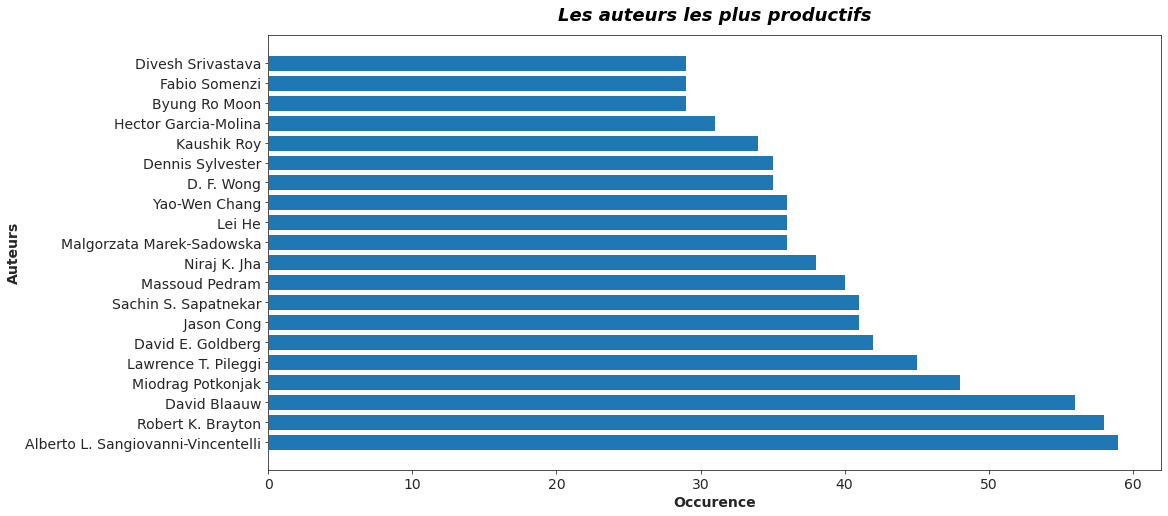

In [ ]:
auth = new_frame["Authors"]
auths=[]
for x in auth :
    x[-1]+=","
    auths.append(",".join(x))
    
auth_sent = " ".join(auths)

def word_count(str):
    counts = {}
    words = str.split(",")

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

df_auth = pd.DataFrame(word_count(auth_sent).items(), columns=['Author', 'Occurence'])
df_auth.sort_values(by=['Occurence'], ascending=False, inplace=True)

sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.figure(figsize=(16,8))
plt.xlabel('Occurence', fontsize=14,fontweight='bold')
plt.ylabel('Auteurs', fontsize=14,fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les auteurs les plus productifs', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_auth["Author"].head(20), df_auth["Occurence"].head(20))

#### Les articles les plus populaires (nombre de citations) : 

<BarContainer object of 20 artists>

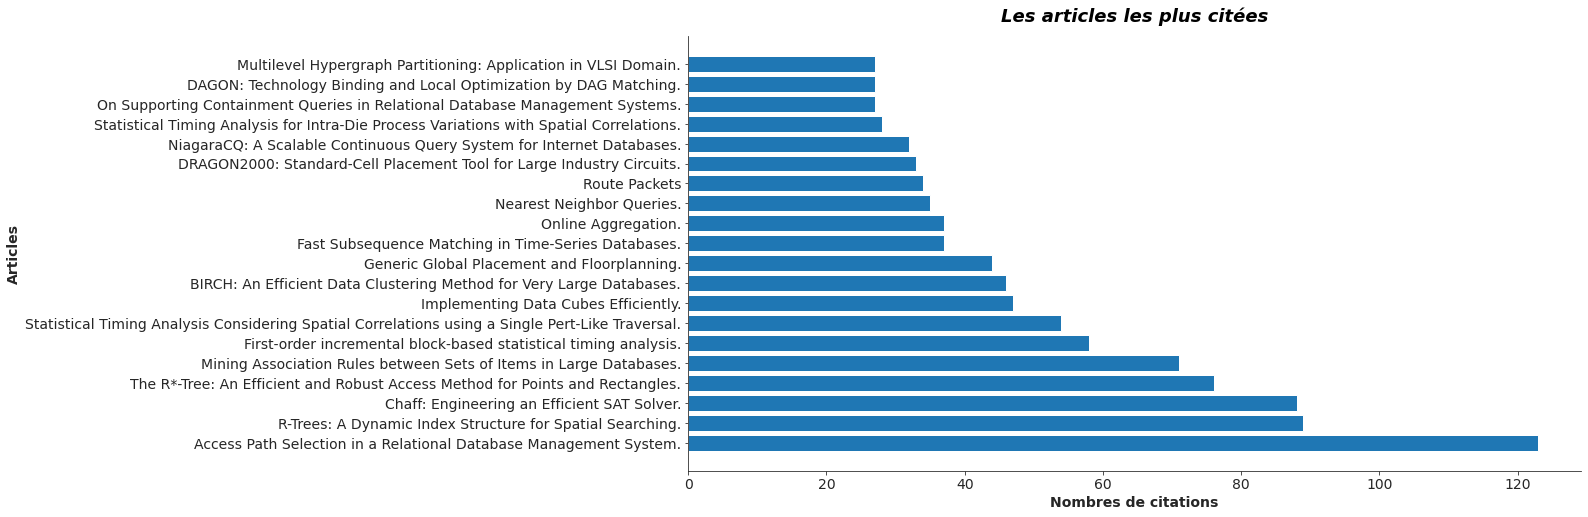

In [ ]:
ref_id = new_frame["Reference_id"]
refs=[]
for x in ref_id :
    if x:
        x[-1]+=","
        refs.append(",".join(x))
    
ref_sent = " ".join(refs)

df_ref = pd.DataFrame(word_count(ref_sent).items(), columns=['Article', 'Occurence'])
df_ref.sort_values(by=['Occurence'], ascending=False, inplace=True)
df_ref.columns = ["ref_article","Occurence"]

true_ref = list(new_frame["Index_id"])
df_ref.drop(df_ref[~df_ref["ref_article"].isin(true_ref)].index, inplace=True)

ref_list=list(df_ref["ref_article"])
title_list=[]
for x in ref_list:
    title_list.append(pd.DataFrame(new_frame['PaperTitle'])[new_frame["Index_id"]==x].iloc[0,0])
df_ref["PaperTitle"] = title_list

plt.figure(figsize=(16,8))
plt.xlabel('Nombres de citations', fontsize=14,fontweight='bold')
plt.ylabel('Articles', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les articles les plus citées', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ref["PaperTitle"].head(20), df_ref["Occurence"].head(20))

#### Les années avec une grande productivité :

<BarContainer object of 20 artists>

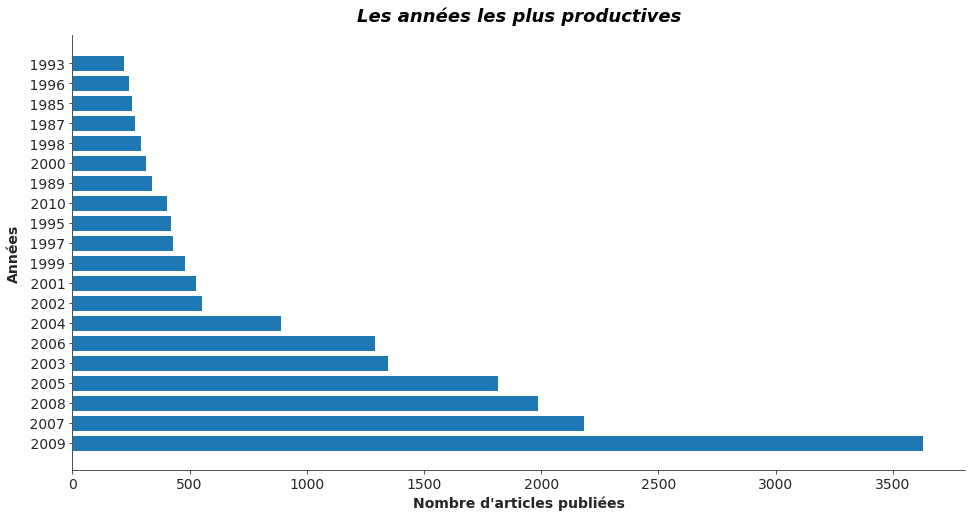

In [ ]:
year = new_frame["Year"]
years=[]
for x in year :
    if x:
        x+=","
        years.append("".join(x))
    
year_sent = " ".join(years)

df_year = pd.DataFrame(word_count(year_sent).items(), columns=['Year', 'Occurence'])
df_year.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Nombre d'articles publiées", fontsize=14,fontweight='bold')
plt.ylabel('Années', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les années les plus productives', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_year["Year"].head(20), df_year["Occurence"].head(20))

#### Distribution du nombre d’articles par revue/conférence :

<BarContainer object of 20 artists>

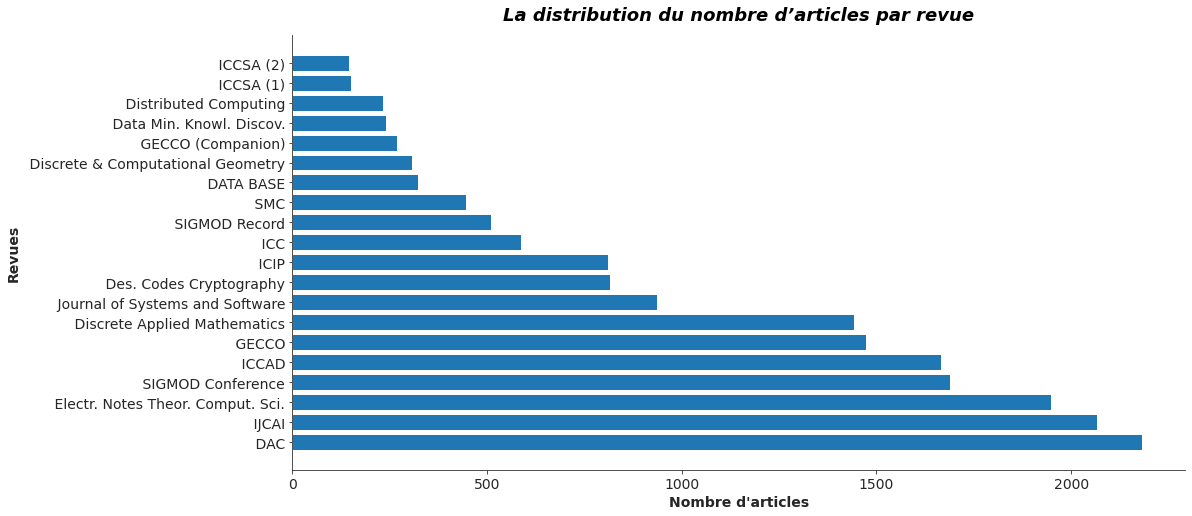

In [ ]:
pub_ven = new_frame["Publication_venue"]
vens=[]
for x in pub_ven :
    if x:
        x+=","
        vens.append("".join(x))
    
vens_sent = " ".join(vens)

df_ven = pd.DataFrame(word_count(vens_sent).items(), columns=['Publication_venue', 'Occurence'])
df_ven.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Nombre d'articles", fontsize=14,fontweight='bold')
plt.ylabel('Revues', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('La distribution du nombre d’articles par revue', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ven["Publication_venue"].head(20), df_ven["Occurence"].head(20))

#### Distribution du nombre de citations :

<BarContainer object of 15 artists>

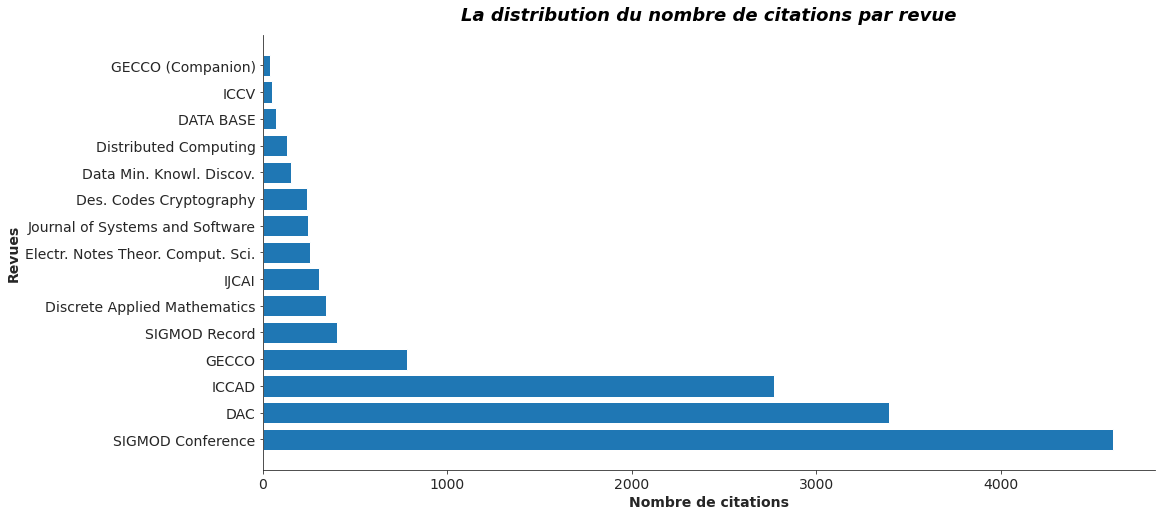

In [ ]:
df_new = df_ref.drop(["ref_article"], axis=1)

dict_pap={}
for i in range(0, len(df_new)):
    dict_pap.update({df_new.iloc[i,1] : df_new.iloc[i,0]})
    
dict_ven={}
ven_list=new_frame["Publication_venue"].unique()
for i in range(0, len(ven_list)):
    dict_ven.update({ven_list[i] : 0})
    
papr_list = list(df_new["PaperTitle"])
dict_pap_ven={}
for x in range(0, len(new_frame)):
    if new_frame.iloc[x,0] in papr_list:
        dict_pap_ven.update({new_frame.iloc[x,0] : new_frame.iloc[x,3]}) 
        
for x,y in dict_ven.items():
    for a,b in dict_pap_ven.items() :
        if b==x :
            dict_ven[x]+=dict_pap[a]
            
df_ven_cit = pd.DataFrame(dict_ven.items(), columns=['Publication_venue', 'nbr_citations'])
df_ven_cit.sort_values(by=['nbr_citations'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Nombre de citations", fontsize=14,fontweight='bold')
plt.ylabel('Revues', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('La distribution du nombre de citations par revue', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh(df_ven_cit["Publication_venue"].head(15), df_ven_cit["nbr_citations"].head(15))

#### Les termes les plus utilisés :

<BarContainer object of 15 artists>

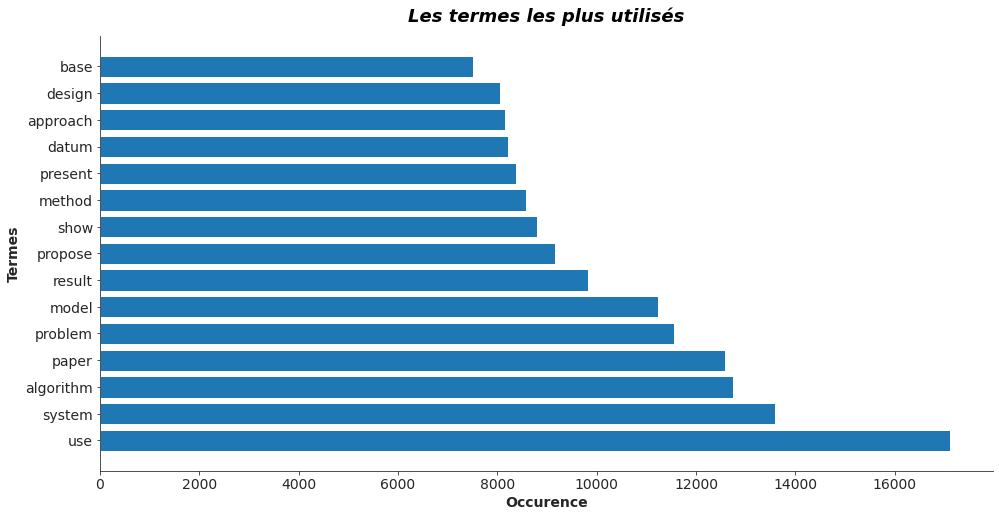

In [ ]:
abst_sent = " ".join(abstracts_lemmatised)

def word_count_abs(str):
    counts = {}
    words = str.split(" ")

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

freq_words = word_count_abs(abst_sent)

df_freq_words = pd.DataFrame(freq_words.items(), columns=['Words', 'Occurence'])
df_freq_words.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Termes', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les termes les plus utilisés', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh(df_freq_words["Words"].head(15), df_freq_words["Occurence"].head(15))

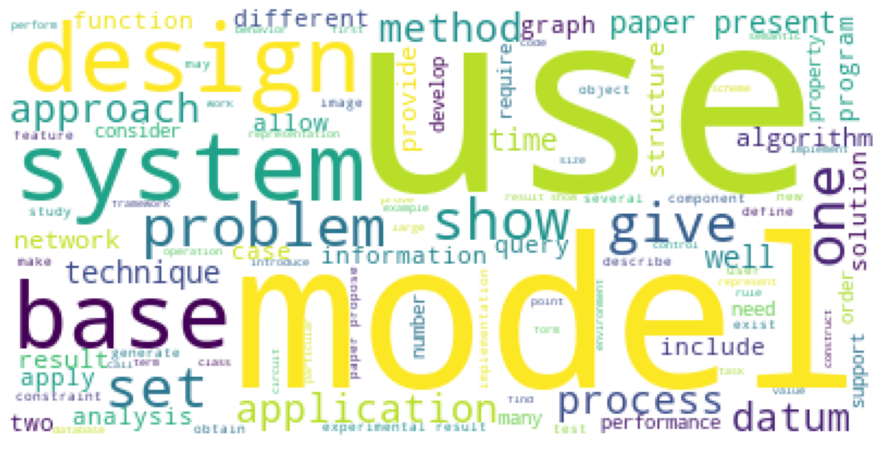

In [ ]:
wordcloud = WordCloud(background_color = 'white', max_words = 100).generate(abst_sent)

plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Partie 3. Classification non supervisée

### K-Means

Afin de pouvoir utiliser K-Means sur les matrices documents-termes et documents-entités, nous allons appliquer une SVD sur ces matrices pour réduire leur dimmensionnalité. Nous choisissons **200** comme nombre de composantes de la nouvelle matrice réduite pour des raisons de complexité et temps d'exécution.

Un autre problème se pose qui est le nombre de classes à prédire. Nous constatons que la variable cible se compose de **36** classes ce qui rend leur interprétation en des clusters très compliquée voire impossible. Pour remédier à ce problème, nous avons pensé à utiliser la méthode de coude "Elbow Method" qui sert à dégager le nombre de classes K optimal pour appliquer le K-Means.

#### SVD sur la matrice documents-termes et application de la méthode de coude

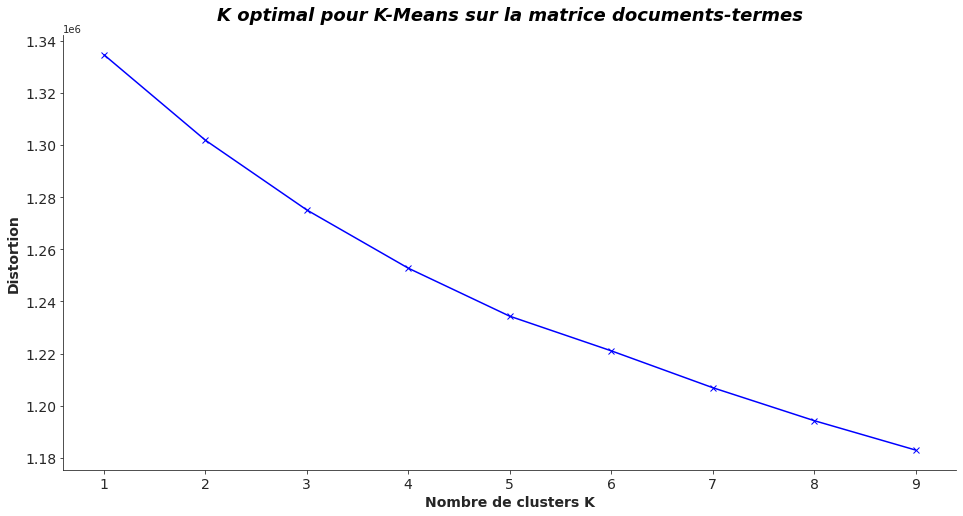

In [ ]:
mat_doct_red = TruncatedSVD(n_components = 200 ).fit(DocTerm_abstract).transform(DocTerm_abstract)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state = 0, n_init=10, max_iter=300)
    kmeanModel.fit(mat_doct_red)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.xlabel("Nombre de clusters K", fontsize=14,fontweight='bold')
plt.ylabel('Distortion', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('K optimal pour K-Means sur la matrice documents-termes', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.plot(K, distortions, 'bx-')
plt.show()

Nous remarquons que la méthode de coude n'a pas clairement fourni un k optimal puisqu'il n'existe pas un vrai point d'inflection dans la courbe. Nous avons décidé de procéder avec un K=4 puisqu'au-delà de 4, le temps d'exécution des différentes commandes augmente significativement.

#### SVD sur la matrice documents-entités et application de la méthode de coude

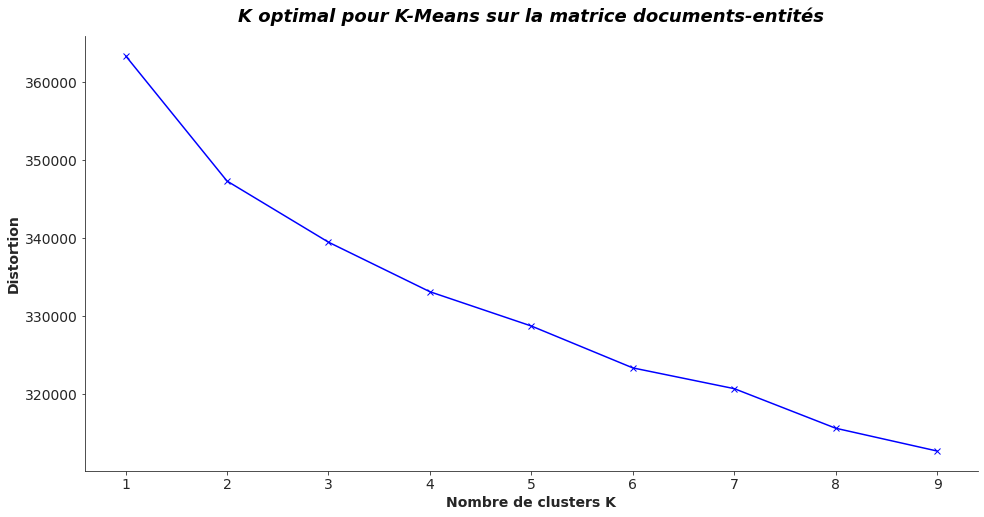

In [ ]:
mat_docent_red = TruncatedSVD(n_components = 200 ).fit(X_entity_linking).transform(X_entity_linking)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state = 0 , n_init=10, max_iter=300)
    kmeanModel.fit(mat_docent_red)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.xlabel("Nombre de clusters K", fontsize=14,fontweight='bold')
plt.ylabel('Distortion', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('K optimal pour K-Means sur la matrice documents-entités', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.plot(K, distortions, 'bx-')
plt.show()

Contrairement à la matrice documents-termes, la méthode de coude appliquée à la matrice documents-entités renvoie une information sur le choix de K. Nous remarquons sur la courbe un point d'inflection au niveau de k=2. Du coup, nous allons procéder avec 2 clusters pour la matrice documents-entités.

#### Application du K-Means avec K=4 sur la matrice documents-termes

In [ ]:
kmeans_doct = KMeans(4, random_state = 0 , n_init=10, max_iter=300).fit(mat_doct_red)
labels_doc_term = kmeans_doct.labels_ # Récupérer les labels
new_frame["Labels_Doc_Term"] = labels_doc_term # Insérer une nouvelle variable contenant les labels dans la base de données

#### Application du K-Means avec K=2 sur la matrice documents-entités

In [ ]:
kmeans_docent = KMeans(2, random_state = 0 , n_init=10, max_iter=300).fit(mat_docent_red)
labels_doc_ent = kmeans_docent.labels_ # Récupérer les labels
new_frame["Labels_Doc_Ent"] = labels_doc_ent # Insérer une nouvelle variable contenant les labels dans la base de données

#### Création des sous bases de données pour chaque cluster

In [ ]:
new_frame["Entities_labels"] = listEntity_label # Contient les entités pour chaque document

df_doc_term_clust_0 = new_frame[new_frame["Labels_Doc_Term"] == 0]
df_doc_term_clust_1 = new_frame[new_frame["Labels_Doc_Term"] == 1]
df_doc_term_clust_2 = new_frame[new_frame["Labels_Doc_Term"] == 2]
df_doc_term_clust_3 = new_frame[new_frame["Labels_Doc_Term"] == 3]

df_doc_ent_clust_0 = new_frame[new_frame["Labels_Doc_Ent"] == 0]
df_doc_ent_clust_1 = new_frame[new_frame["Labels_Doc_Ent"] == 1]


#### Les termes les plus fréquents

###### Cluster 0

<BarContainer object of 15 artists>

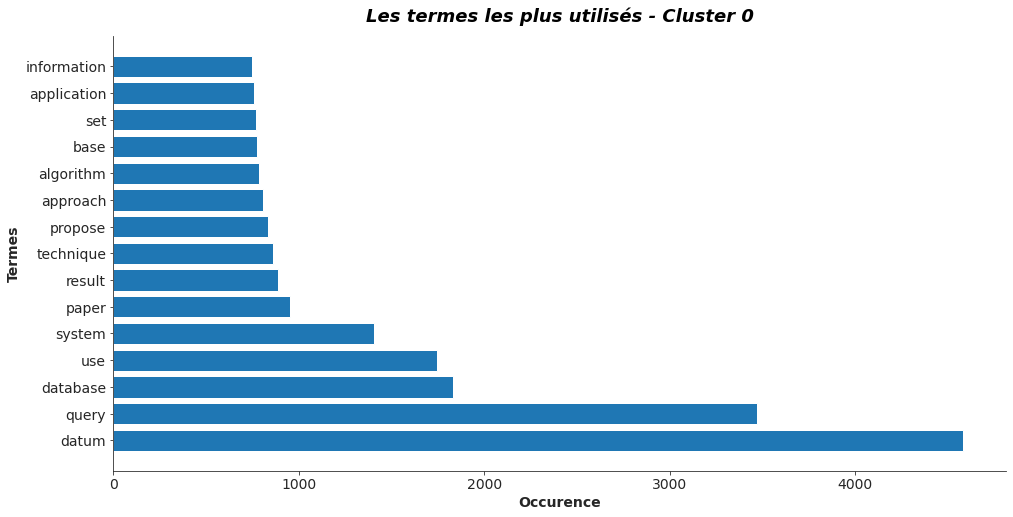

In [ ]:
abst_sent_clust0 = " ".join(list(df_doc_term_clust_0["Abstract"]))

def word_count_abs(str):
    counts = {}
    words = str.split(" ")

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

freq_words_clust0 = word_count_abs(abst_sent_clust0)

df_freq_words_clust0 = pd.DataFrame(freq_words_clust0.items(), columns=['Words', 'Occurence'])
df_freq_words_clust0.sort_values(by=['Occurence'], ascending=False, inplace=True)


plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Termes', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les termes les plus utilisés - Cluster 0', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh(df_freq_words_clust0["Words"].head(15), df_freq_words_clust0["Occurence"].head(15))

Nous remarquons que pour le Cluster 0 les termes les plus fréquents sont **datum** avec plus de 4000 occurence suivi par **query** avec plus de 3000 occurence. Par la suite **database**, **use** et **system** avec des occurences entre 1000 et 2000.

###### Cluster 1

<BarContainer object of 15 artists>

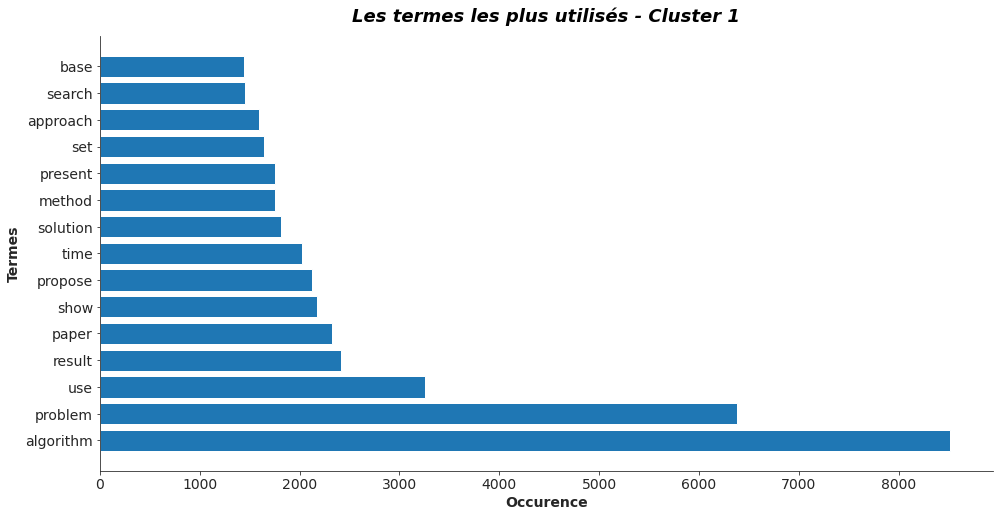

In [ ]:
abst_sent_clust1 = " ".join(list(df_doc_term_clust_1["Abstract"]))

def word_count_abs(str):
    counts = {}
    words = str.split(" ")

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

freq_words_clust1 = word_count_abs(abst_sent_clust1)

df_freq_words_clust1 = pd.DataFrame(freq_words_clust1.items(), columns=['Words', 'Occurence'])
df_freq_words_clust1.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Termes', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les termes les plus utilisés - Cluster 1', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh(df_freq_words_clust1["Words"].head(15), df_freq_words_clust1["Occurence"].head(15))

###### Cluster 2

<BarContainer object of 15 artists>

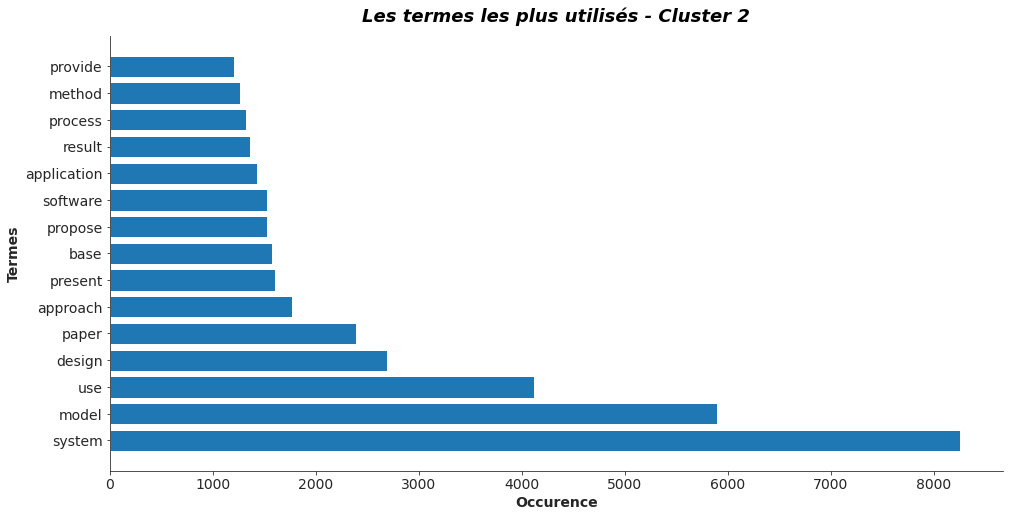

In [ ]:
abst_sent_clust2 = " ".join(list(df_doc_term_clust_2["Abstract"]))

def word_count_abs(str):
    counts = {}
    words = str.split(" ")

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

freq_words_clust2 = word_count_abs(abst_sent_clust2)

df_freq_words_clust2 = pd.DataFrame(freq_words_clust2.items(), columns=['Words', 'Occurence'])
df_freq_words_clust2.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Termes', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les termes les plus utilisés - Cluster 2', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh(df_freq_words_clust2["Words"].head(15), df_freq_words_clust2["Occurence"].head(15))

###### Cluster 3

<BarContainer object of 15 artists>

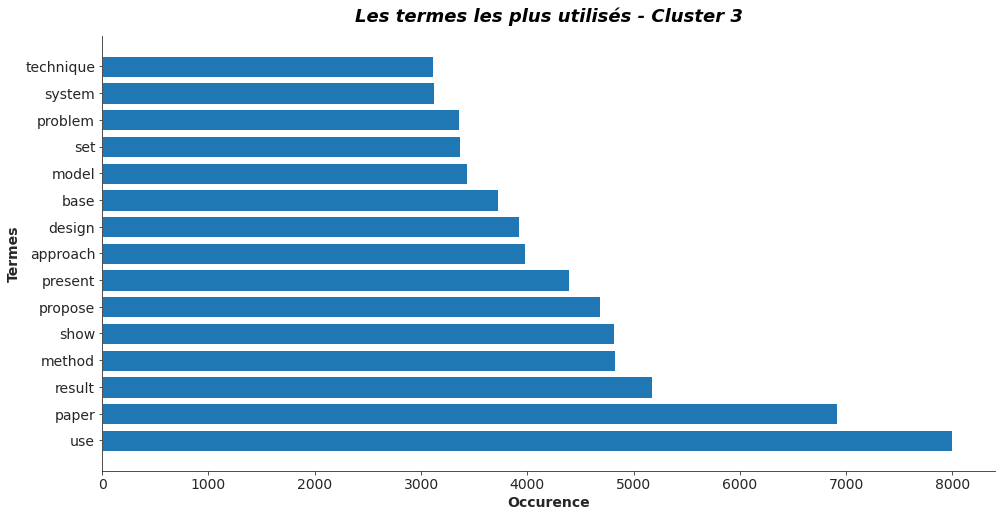

In [ ]:
abst_sent_clust3 = " ".join(list(df_doc_term_clust_3["Abstract"]))

def word_count_abs(str):
    counts = {}
    words = str.split(" ")

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

freq_words_clust3 = word_count_abs(abst_sent_clust3)

df_freq_words_clust3 = pd.DataFrame(freq_words_clust3.items(), columns=['Words', 'Occurence'])
df_freq_words_clust3.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Termes', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les termes les plus utilisés - Cluster 3', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh(df_freq_words_clust3["Words"].head(15), df_freq_words_clust3["Occurence"].head(15))

#### Les entités les plus fréquentes

###### Cluster 0

<BarContainer object of 15 artists>

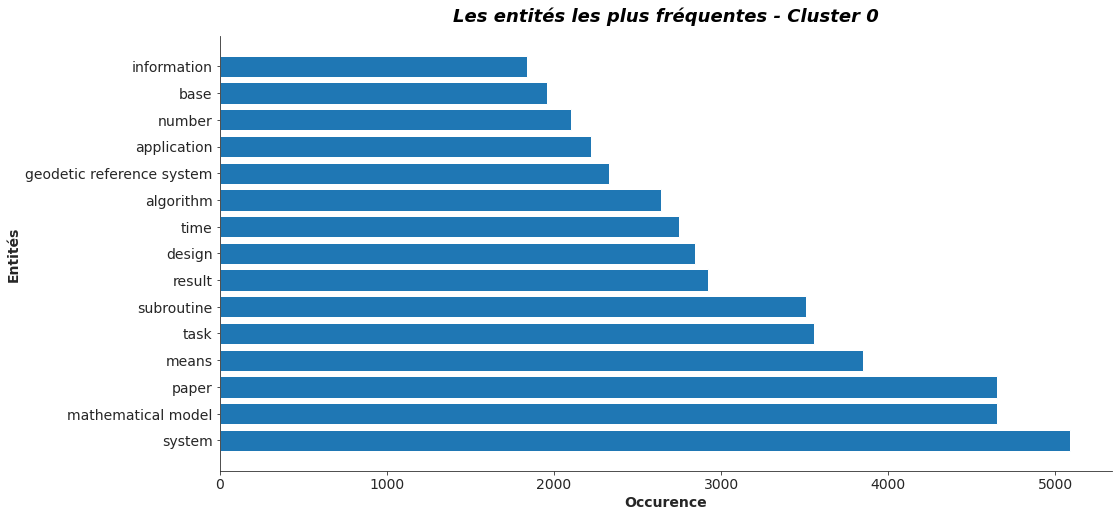

In [ ]:
ent_lab_clust0 = list(df_doc_ent_clust_0["Entities_labels"])
ents_clust0=[]
for x in ent_lab_clust0 :
    if x:
        x[-1]+=","
        ents_clust0.append(",".join(x))
    
ent_sent_clust0 = " ".join(ents_clust0)

freq_ent_clust0 = word_count(ent_sent_clust0)

df_ent_clust0 = pd.DataFrame(freq_ent_clust0.items(), columns=['Entities', 'Occurence'])
nan_value = float("NaN")
df_ent_clust0.replace("", nan_value, inplace=True)
df_ent_clust0.dropna(inplace=True)
df_ent_clust0.sort_values(by=['Occurence'], ascending=False, inplace=True)


plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Entités', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les entités les plus fréquentes - Cluster 0', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh(df_ent_clust0["Entities"].head(15), df_ent_clust0["Occurence"].head(15))

###### Cluster 1

<BarContainer object of 15 artists>

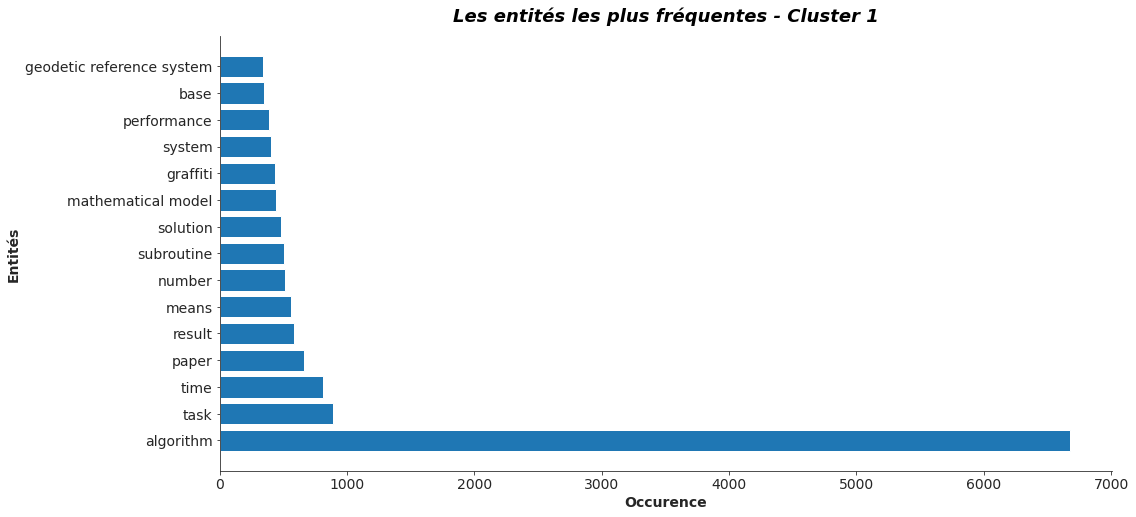

In [ ]:
ent_lab_clust1 = list(df_doc_ent_clust_1["Entities_labels"])
ents_clust1=[]
for x in ent_lab_clust1 :
    if x:
        x[-1]+=","
        ents_clust1.append(",".join(x))
    
ent_sent_clust1 = " ".join(ents_clust1)

freq_ent_clust1 = word_count(ent_sent_clust1)

df_ent_clust1 = pd.DataFrame(freq_ent_clust1.items(), columns=['Entities', 'Occurence'])
nan_value = float("NaN")
df_ent_clust1.replace("", nan_value, inplace=True)
df_ent_clust1.dropna(inplace=True)
df_ent_clust1.sort_values(by=['Occurence'], ascending=False, inplace=True)


plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Entités', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les entités les plus fréquentes - Cluster 1', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh(df_ent_clust1["Entities"].head(15), df_ent_clust1["Occurence"].head(15))

#### Le type de revues

###### Cluster 0 / Matrice documents-termes

<BarContainer object of 20 artists>

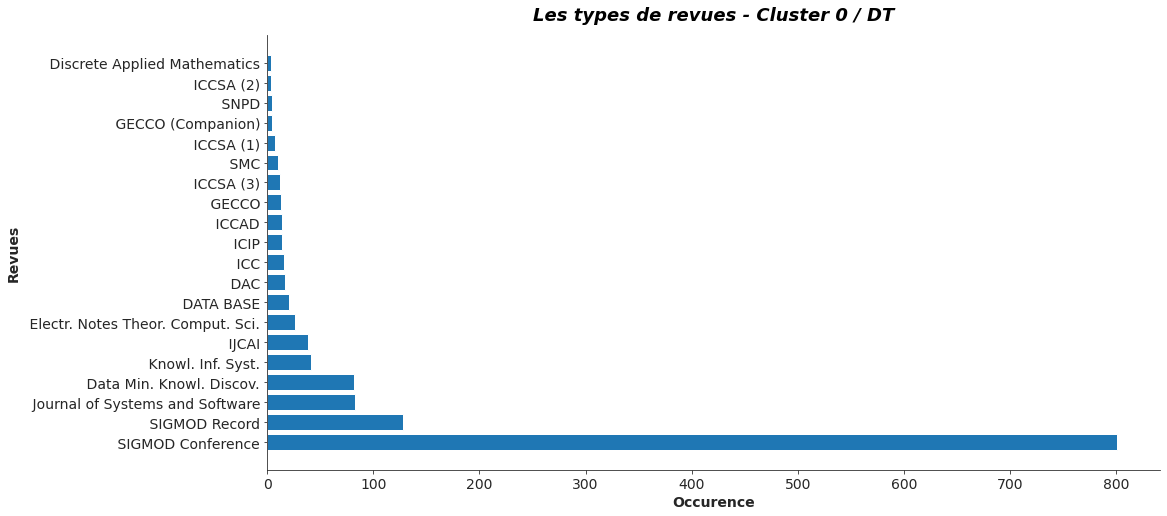

In [ ]:
pub_ven = df_doc_term_clust_0["Publication_venue"]
vens=[]
for x in pub_ven :
    if x:
        x+=","
        vens.append("".join(x))
    
vens_sent = " ".join(vens)

df_ven = pd.DataFrame(word_count(vens_sent).items(), columns=['Publication_venue', 'Occurence'])
df_ven.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Revues', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les types de revues - Cluster 0 / DT', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ven["Publication_venue"].head(20), df_ven["Occurence"].head(20))

###### Cluster 1 / Matrice documents-termes

<BarContainer object of 20 artists>

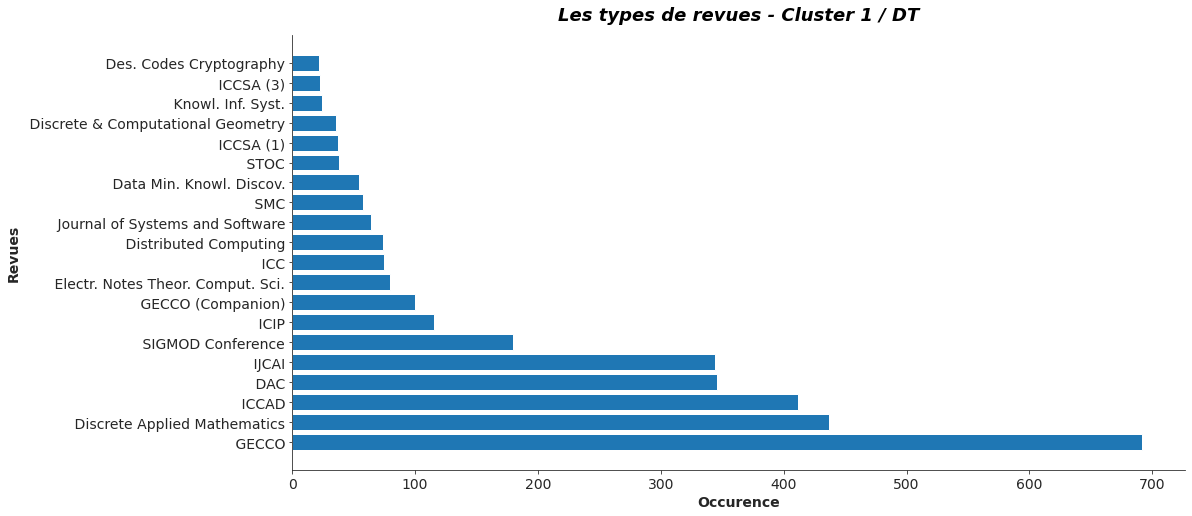

In [ ]:
pub_ven = df_doc_term_clust_1["Publication_venue"]
vens=[]
for x in pub_ven :
    if x:
        x+=","
        vens.append("".join(x))
    
vens_sent = " ".join(vens)

df_ven = pd.DataFrame(word_count(vens_sent).items(), columns=['Publication_venue', 'Occurence'])
df_ven.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Revues', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les types de revues - Cluster 1 / DT', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ven["Publication_venue"].head(20), df_ven["Occurence"].head(20))

###### Cluster 2 / Matrice documents-termes

<BarContainer object of 20 artists>

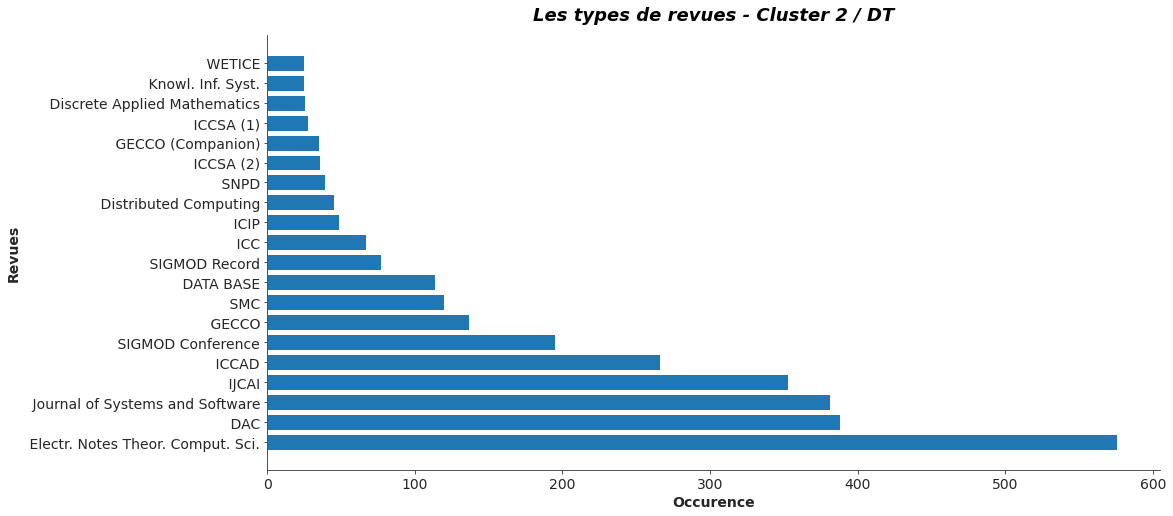

In [ ]:
pub_ven = df_doc_term_clust_2["Publication_venue"]
vens=[]
for x in pub_ven :
    if x:
        x+=","
        vens.append("".join(x))
    
vens_sent = " ".join(vens)

df_ven = pd.DataFrame(word_count(vens_sent).items(), columns=['Publication_venue', 'Occurence'])
df_ven.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Revues', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les types de revues - Cluster 2 / DT', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ven["Publication_venue"].head(20), df_ven["Occurence"].head(20))

###### Cluster 3 / Matrice documents-termes

<BarContainer object of 20 artists>

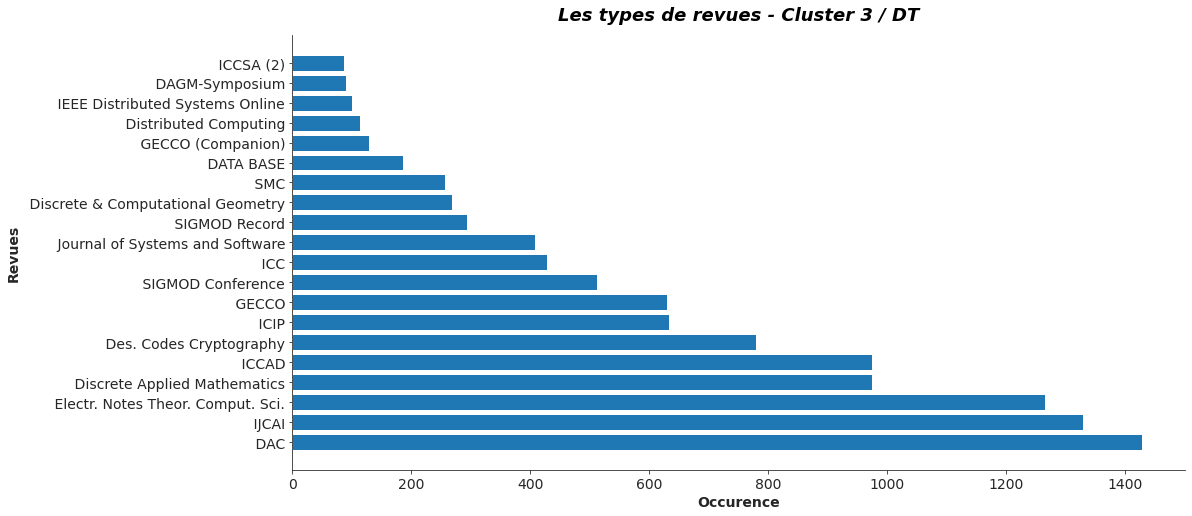

In [ ]:
pub_ven = df_doc_term_clust_3["Publication_venue"]
vens=[]
for x in pub_ven :
    if x:
        x+=","
        vens.append("".join(x))
    
vens_sent = " ".join(vens)

df_ven = pd.DataFrame(word_count(vens_sent).items(), columns=['Publication_venue', 'Occurence'])
df_ven.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Revues', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les types de revues - Cluster 3 / DT', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ven["Publication_venue"].head(20), df_ven["Occurence"].head(20))

###### Cluster 0 / Matrice documents-entités

<BarContainer object of 20 artists>

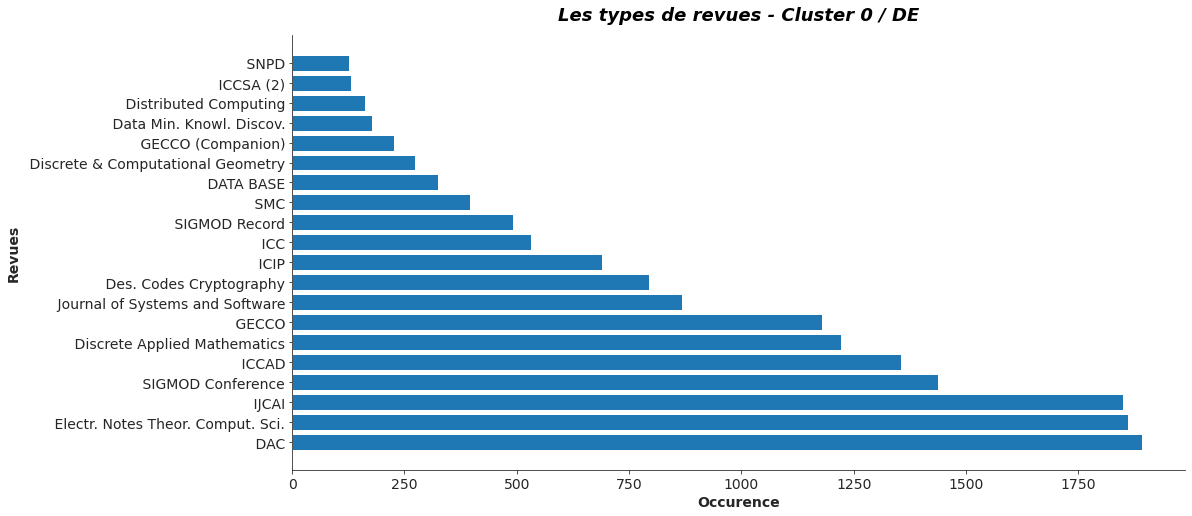

In [ ]:
pub_ven = df_doc_ent_clust_0["Publication_venue"]
vens=[]
for x in pub_ven :
    if x:
        x+=","
        vens.append("".join(x))
    
vens_sent = " ".join(vens)

df_ven = pd.DataFrame(word_count(vens_sent).items(), columns=['Publication_venue', 'Occurence'])
df_ven.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Revues', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les types de revues - Cluster 0 / DE', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ven["Publication_venue"].head(20), df_ven["Occurence"].head(20))

###### Cluster 1 / Matrice documents-entités

<BarContainer object of 20 artists>

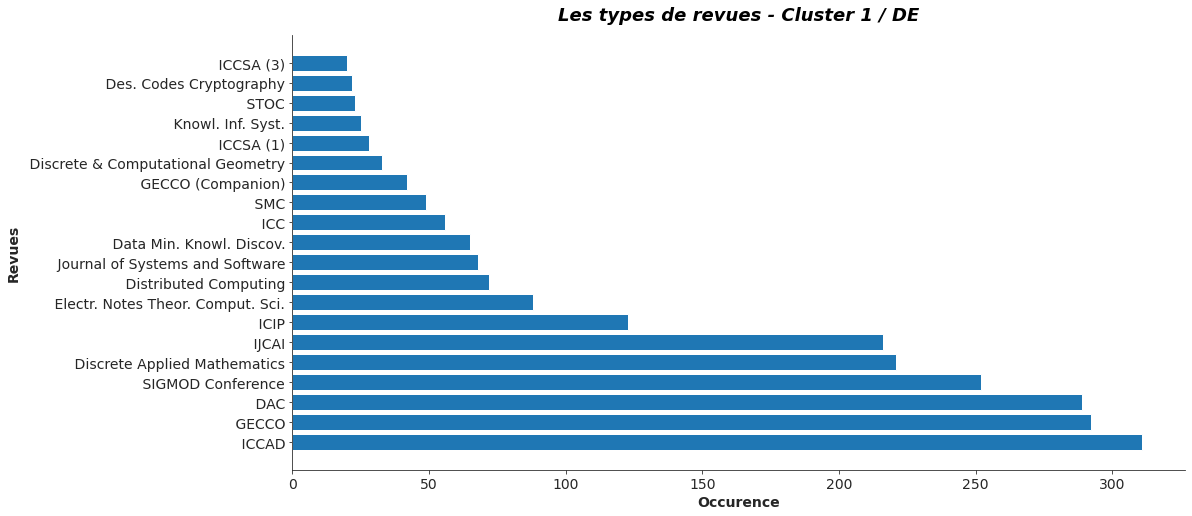

In [ ]:
pub_ven = df_doc_ent_clust_1["Publication_venue"]
vens=[]
for x in pub_ven :
    if x:
        x+=","
        vens.append("".join(x))
    
vens_sent = " ".join(vens)

df_ven = pd.DataFrame(word_count(vens_sent).items(), columns=['Publication_venue', 'Occurence'])
df_ven.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Revues', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les types de revues - Cluster 1 / DE', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ven["Publication_venue"].head(20), df_ven["Occurence"].head(20))

#### Évolution des clusters selon le temps

###### Cluster 0 / Matrice documents-termes

<BarContainer object of 20 artists>

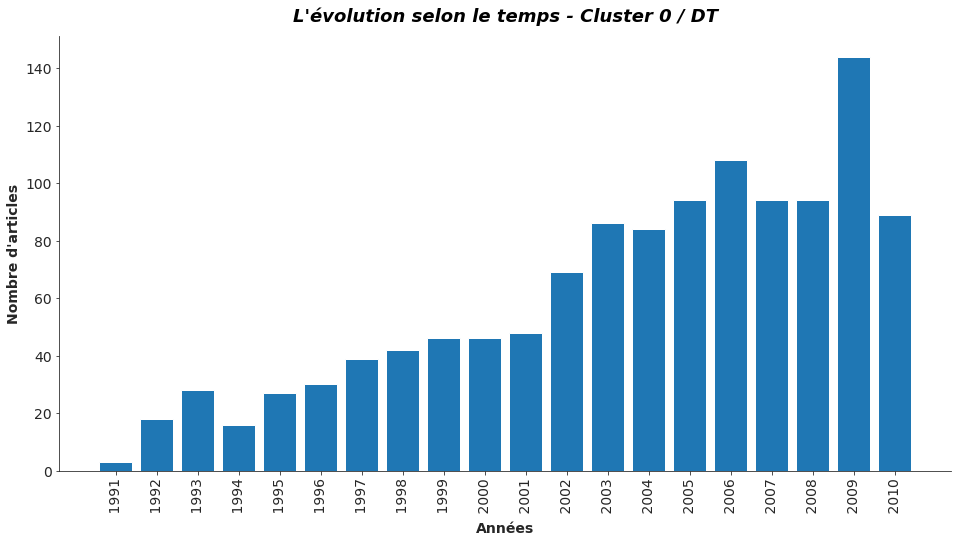

In [ ]:
year = df_doc_term_clust_0["Year"]
years=[]
for x in year :
    if x:
        x+=","
        years.append("".join(x))
    
year_sent = " ".join(years)

df_year = pd.DataFrame(word_count(year_sent).items(), columns=['Year', 'Occurence'])
nan_value = float("NaN")
df_year.replace("", nan_value, inplace=True)
df_year.dropna(inplace=True)
df_year.sort_values(by=['Year'], ascending=True, inplace=True)
df_year.drop(df_year.tail(1).index,inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Années", fontsize=14,fontweight='bold')
plt.ylabel("Nombre d'articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
plt.title("L'évolution selon le temps - Cluster 0 / DT", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.bar( df_year["Year"].tail(20), df_year["Occurence"].tail(20))

###### Cluster 1 / Matrice documents-termes

<BarContainer object of 20 artists>

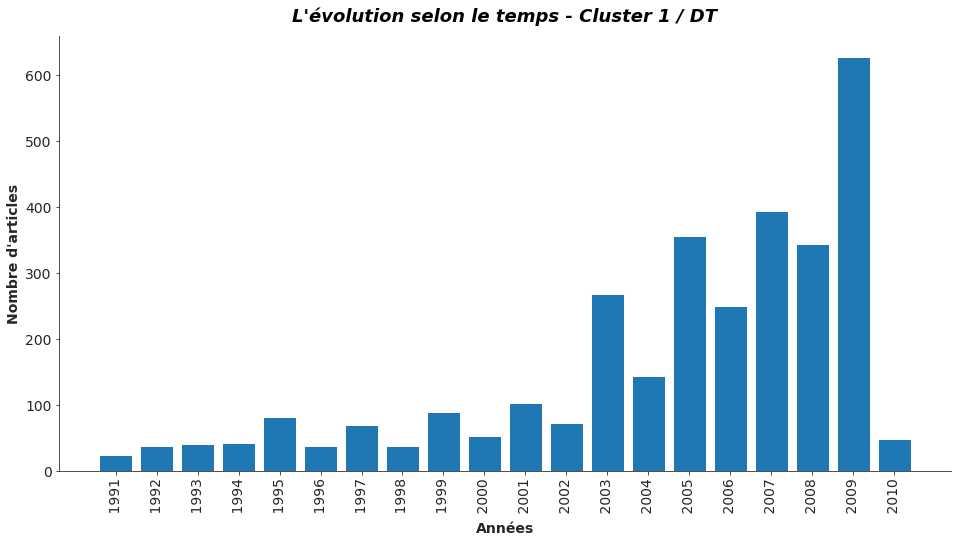

In [ ]:
year = df_doc_term_clust_1["Year"]
years=[]
for x in year :
    if x:
        x+=","
        years.append("".join(x))
    
year_sent = " ".join(years)

df_year = pd.DataFrame(word_count(year_sent).items(), columns=['Year', 'Occurence'])
nan_value = float("NaN")
df_year.replace("", nan_value, inplace=True)
df_year.dropna(inplace=True)
df_year.sort_values(by=['Year'], ascending=True, inplace=True)
df_year.drop(df_year.tail(1).index,inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Années", fontsize=14,fontweight='bold')
plt.ylabel("Nombre d'articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
plt.title("L'évolution selon le temps - Cluster 1 / DT", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.bar( df_year["Year"].tail(20), df_year["Occurence"].tail(20))

###### Cluster 2 / Matrice documents-termes

<BarContainer object of 20 artists>

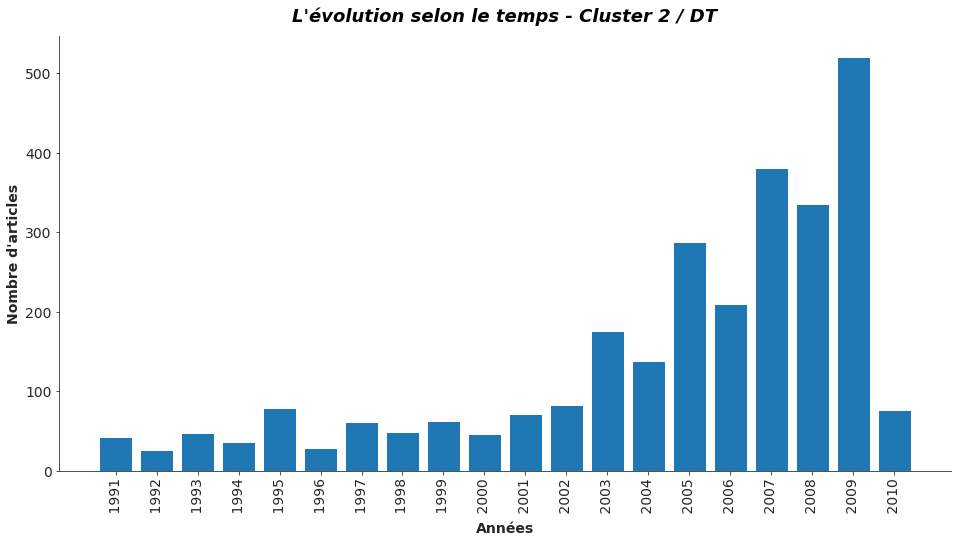

In [ ]:
year = df_doc_term_clust_2["Year"]
years=[]
for x in year :
    if x:
        x+=","
        years.append("".join(x))
    
year_sent = " ".join(years)

df_year = pd.DataFrame(word_count(year_sent).items(), columns=['Year', 'Occurence'])
nan_value = float("NaN")
df_year.replace("", nan_value, inplace=True)
df_year.dropna(inplace=True)
df_year.sort_values(by=['Year'], ascending=True, inplace=True)
df_year.drop(df_year.tail(1).index,inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Années", fontsize=14,fontweight='bold')
plt.ylabel("Nombre d'articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
plt.title("L'évolution selon le temps - Cluster 2 / DT", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.bar( df_year["Year"].tail(20), df_year["Occurence"].tail(20))

###### Cluster 3 / Matrice documents-termes

<BarContainer object of 20 artists>

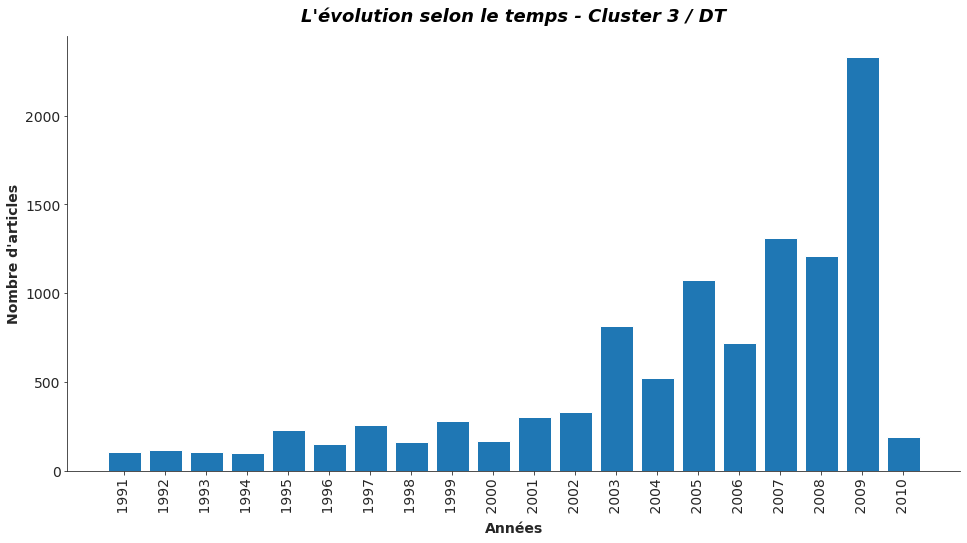

In [ ]:
year = df_doc_term_clust_3["Year"]
years=[]
for x in year :
    if x:
        x+=","
        years.append("".join(x))
    
year_sent = " ".join(years)

df_year = pd.DataFrame(word_count(year_sent).items(), columns=['Year', 'Occurence'])
nan_value = float("NaN")
df_year.replace("", nan_value, inplace=True)
df_year.dropna(inplace=True)
df_year.sort_values(by=['Year'], ascending=True, inplace=True)
df_year.drop(df_year.tail(1).index,inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Années", fontsize=14,fontweight='bold')
plt.ylabel("Nombre d'articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
plt.title("L'évolution selon le temps - Cluster 3 / DT", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.bar( df_year["Year"].tail(20), df_year["Occurence"].tail(20))

###### Cluster 0 / Matrice documents-entités

<BarContainer object of 20 artists>

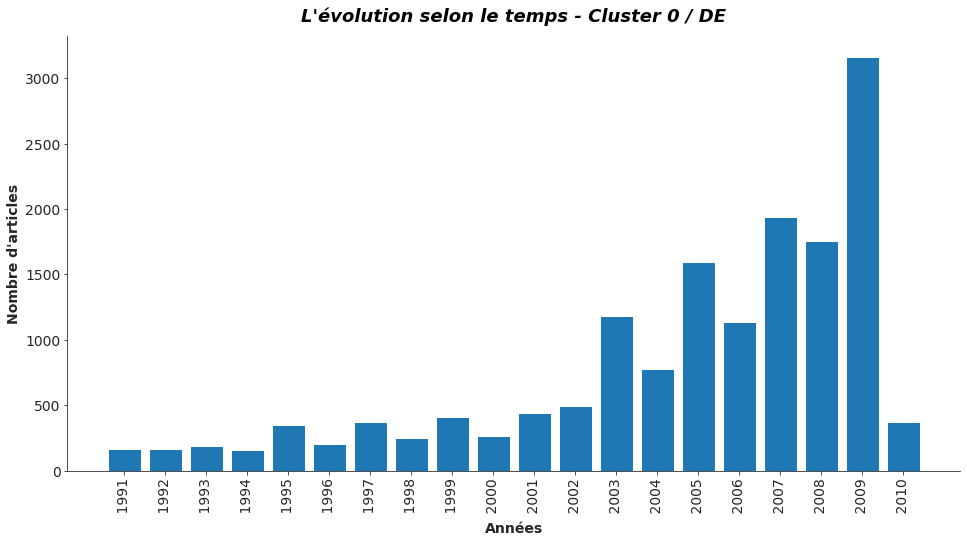

In [ ]:
year = df_doc_ent_clust_0["Year"]
years=[]
for x in year :
    if x:
        x+=","
        years.append("".join(x))
    
year_sent = " ".join(years)

df_year = pd.DataFrame(word_count(year_sent).items(), columns=['Year', 'Occurence'])
nan_value = float("NaN")
df_year.replace("", nan_value, inplace=True)
df_year.dropna(inplace=True)
df_year.sort_values(by=['Year'], ascending=True, inplace=True)
df_year.drop(df_year.tail(1).index,inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Années", fontsize=14,fontweight='bold')
plt.ylabel("Nombre d'articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
plt.title("L'évolution selon le temps - Cluster 0 / DE", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.bar( df_year["Year"].tail(20), df_year["Occurence"].tail(20))

###### Cluster 1 / Matrice documents-entités

<BarContainer object of 20 artists>

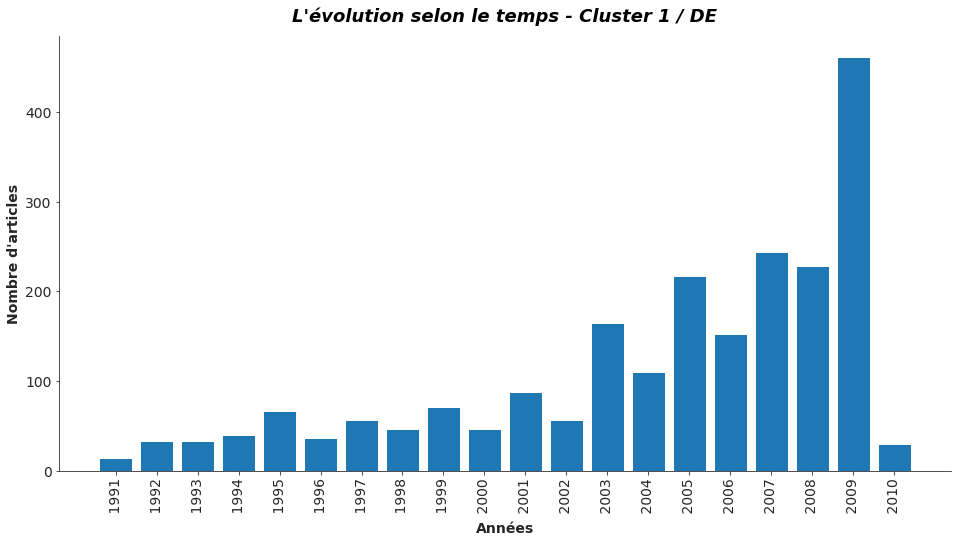

In [ ]:
year = df_doc_ent_clust_1["Year"]
years=[]
for x in year :
    if x:
        x+=","
        years.append("".join(x))
    
year_sent = " ".join(years)

df_year = pd.DataFrame(word_count(year_sent).items(), columns=['Year', 'Occurence'])
nan_value = float("NaN")
df_year.replace("", nan_value, inplace=True)
df_year.dropna(inplace=True)
df_year.sort_values(by=['Year'], ascending=True, inplace=True)
df_year.drop(df_year.tail(1).index,inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Années", fontsize=14,fontweight='bold')
plt.ylabel("Nombre d'articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
plt.title("L'évolution selon le temps - Cluster 1 / DE", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.bar( df_year["Year"].tail(20), df_year["Occurence"].tail(20))

#### Distribution du nombre de citations des articles

###### Cluster 0 / Matrice documents-termes

<BarContainer object of 20 artists>

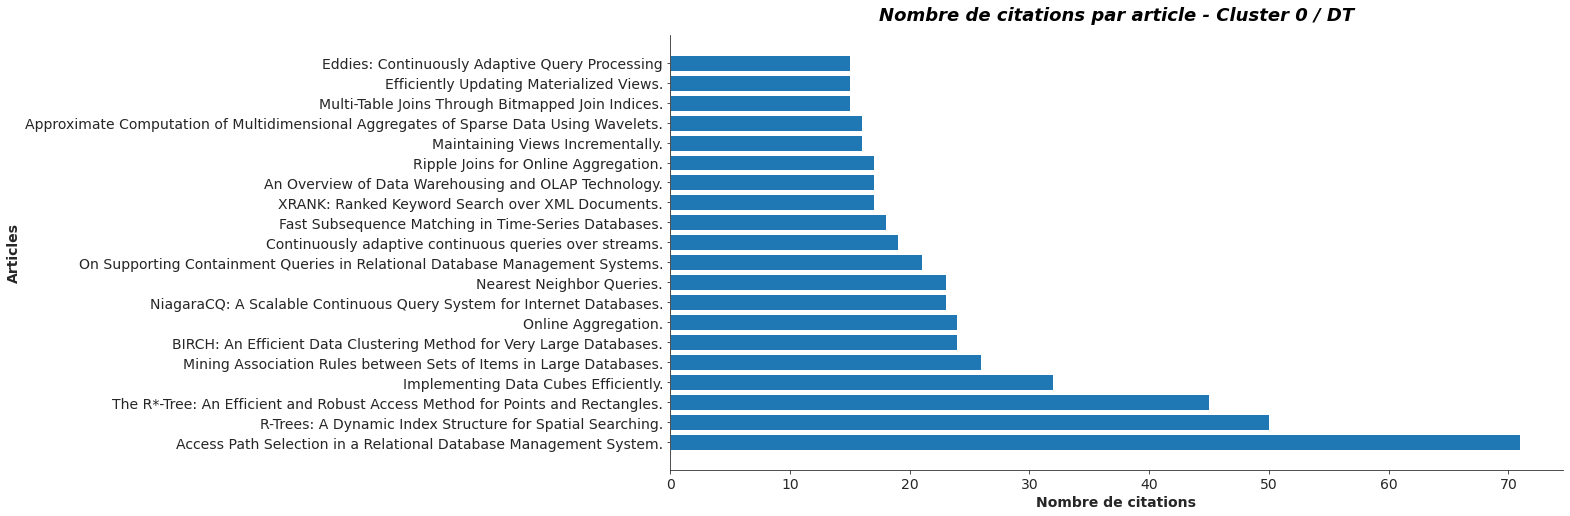

In [ ]:
ref_id = df_doc_term_clust_0["Reference_id"]
refs=[]
for x in ref_id :
    if x:
        x[-1]+=","
        refs.append(",".join(x))
    
ref_sent = " ".join(refs)

df_ref = pd.DataFrame(word_count(ref_sent).items(), columns=['Article', 'Occurence'])
df_ref.sort_values(by=['Occurence'], ascending=False, inplace=True)
df_ref.columns = ["ref_article","Occurence"]

true_ref = list(new_frame["Index_id"])
df_ref.drop(df_ref[~df_ref["ref_article"].isin(true_ref)].index, inplace=True)

ref_list=list(df_ref["ref_article"])
title_list=[]
for x in ref_list:
    title_list.append(pd.DataFrame(new_frame['PaperTitle'])[new_frame["Index_id"]==x].iloc[0,0])
df_ref["PaperTitle"] = title_list

plt.figure(figsize=(16,8))
plt.xlabel("Nombre de citations", fontsize=14,fontweight='bold')
plt.ylabel("Articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Nombre de citations par article - Cluster 0 / DT", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ref["PaperTitle"].head(20), df_ref["Occurence"].head(20))

###### Cluster 1 / Matrice documents-termes

<BarContainer object of 20 artists>

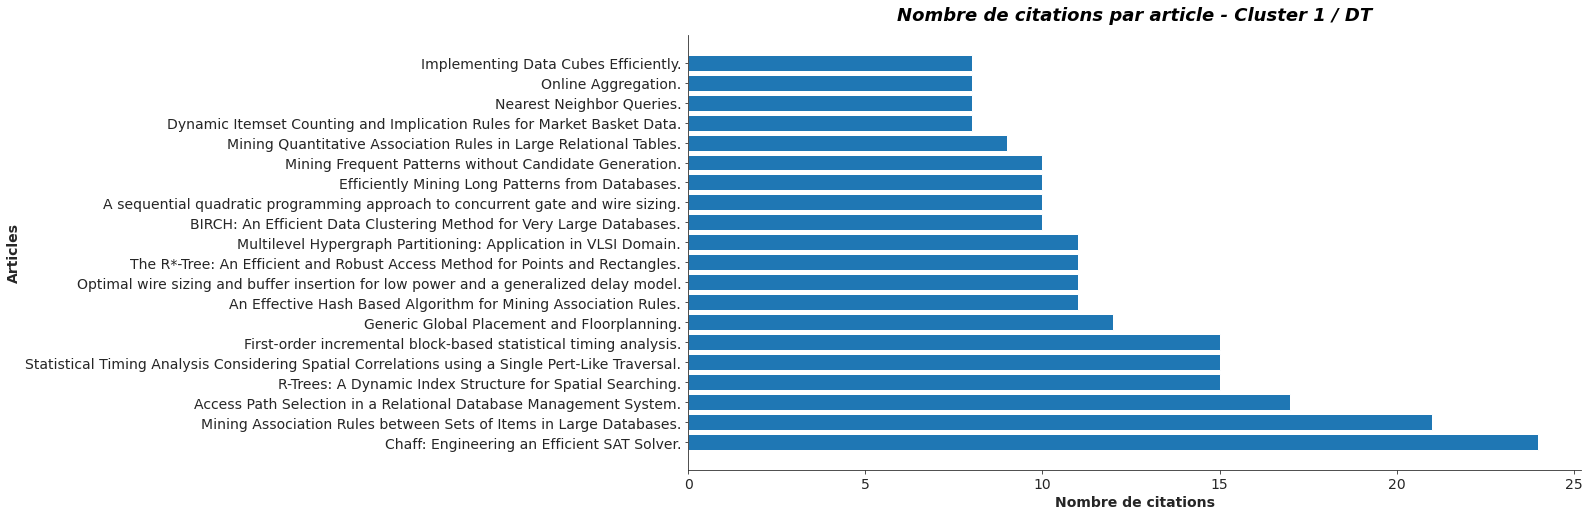

In [ ]:
ref_id = df_doc_term_clust_1["Reference_id"]
refs=[]
for x in ref_id :
    if x:
        x[-1]+=","
        refs.append(",".join(x))
    
ref_sent = " ".join(refs)

df_ref = pd.DataFrame(word_count(ref_sent).items(), columns=['Article', 'Occurence'])
df_ref.sort_values(by=['Occurence'], ascending=False, inplace=True)
df_ref.columns = ["ref_article","Occurence"]

true_ref = list(new_frame["Index_id"])
df_ref.drop(df_ref[~df_ref["ref_article"].isin(true_ref)].index, inplace=True)

ref_list=list(df_ref["ref_article"])
title_list=[]
for x in ref_list:
    title_list.append(pd.DataFrame(new_frame['PaperTitle'])[new_frame["Index_id"]==x].iloc[0,0])
df_ref["PaperTitle"] = title_list

plt.figure(figsize=(16,8))
plt.xlabel("Nombre de citations", fontsize=14,fontweight='bold')
plt.ylabel("Articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Nombre de citations par article - Cluster 1 / DT", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ref["PaperTitle"].head(20), df_ref["Occurence"].head(20))

###### Cluster 2 / Matrice documents-termes

<BarContainer object of 20 artists>

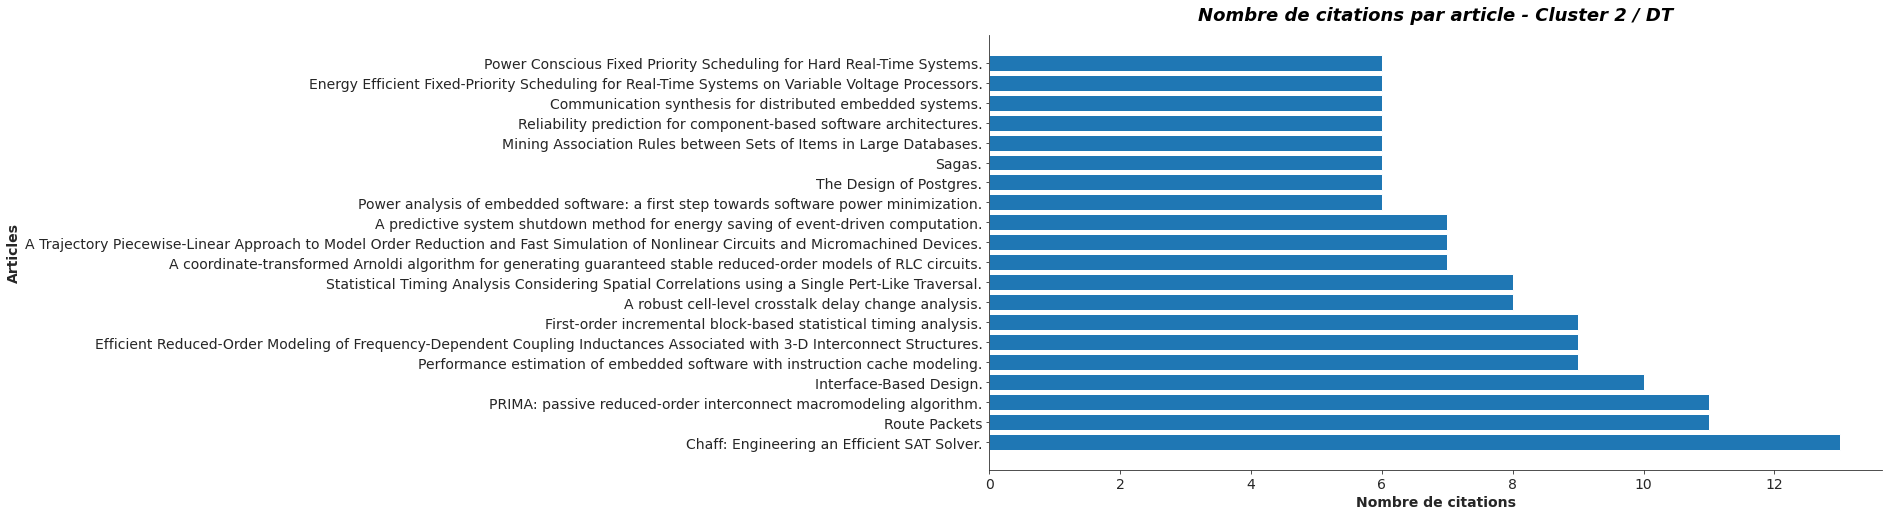

In [ ]:
ref_id = df_doc_term_clust_2["Reference_id"]
refs=[]
for x in ref_id :
    if x:
        x[-1]+=","
        refs.append(",".join(x))
    
ref_sent = " ".join(refs)

df_ref = pd.DataFrame(word_count(ref_sent).items(), columns=['Article', 'Occurence'])
df_ref.sort_values(by=['Occurence'], ascending=False, inplace=True)
df_ref.columns = ["ref_article","Occurence"]

true_ref = list(new_frame["Index_id"])
df_ref.drop(df_ref[~df_ref["ref_article"].isin(true_ref)].index, inplace=True)

ref_list=list(df_ref["ref_article"])
title_list=[]
for x in ref_list:
    title_list.append(pd.DataFrame(new_frame['PaperTitle'])[new_frame["Index_id"]==x].iloc[0,0])
df_ref["PaperTitle"] = title_list

plt.figure(figsize=(16,8))
plt.xlabel("Nombre de citations", fontsize=14,fontweight='bold')
plt.ylabel("Articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Nombre de citations par article - Cluster 2 / DT", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ref["PaperTitle"].head(20), df_ref["Occurence"].head(20))

###### Cluster 3 / Matrice documents-termes

<BarContainer object of 20 artists>

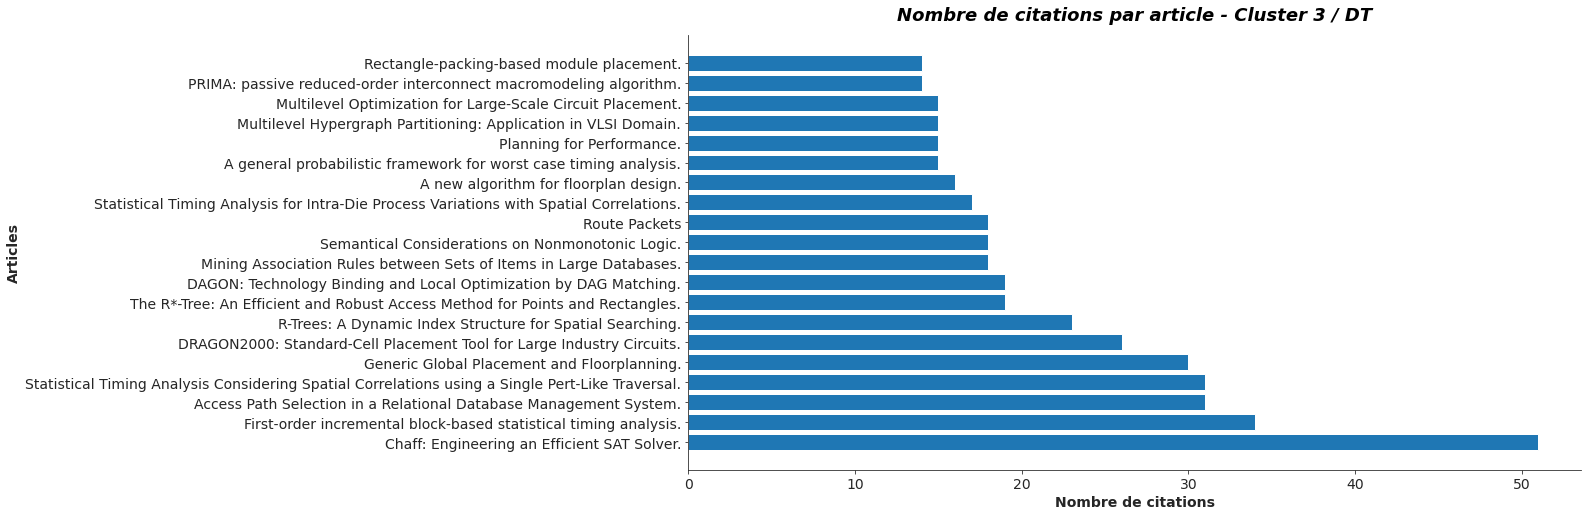

In [ ]:
ref_id = df_doc_term_clust_3["Reference_id"]
refs=[]
for x in ref_id :
    if x:
        x[-1]+=","
        refs.append(",".join(x))
    
ref_sent = " ".join(refs)

df_ref = pd.DataFrame(word_count(ref_sent).items(), columns=['Article', 'Occurence'])
df_ref.sort_values(by=['Occurence'], ascending=False, inplace=True)
df_ref.columns = ["ref_article","Occurence"]

true_ref = list(new_frame["Index_id"])
df_ref.drop(df_ref[~df_ref["ref_article"].isin(true_ref)].index, inplace=True)

ref_list=list(df_ref["ref_article"])
title_list=[]
for x in ref_list:
    title_list.append(pd.DataFrame(new_frame['PaperTitle'])[new_frame["Index_id"]==x].iloc[0,0])
df_ref["PaperTitle"] = title_list

plt.figure(figsize=(16,8))
plt.xlabel("Nombre de citations", fontsize=14,fontweight='bold')
plt.ylabel("Articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Nombre de citations par article - Cluster 3 / DT", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ref["PaperTitle"].head(20), df_ref["Occurence"].head(20))

###### Cluster 0 / Matrice documents-entités

<BarContainer object of 20 artists>

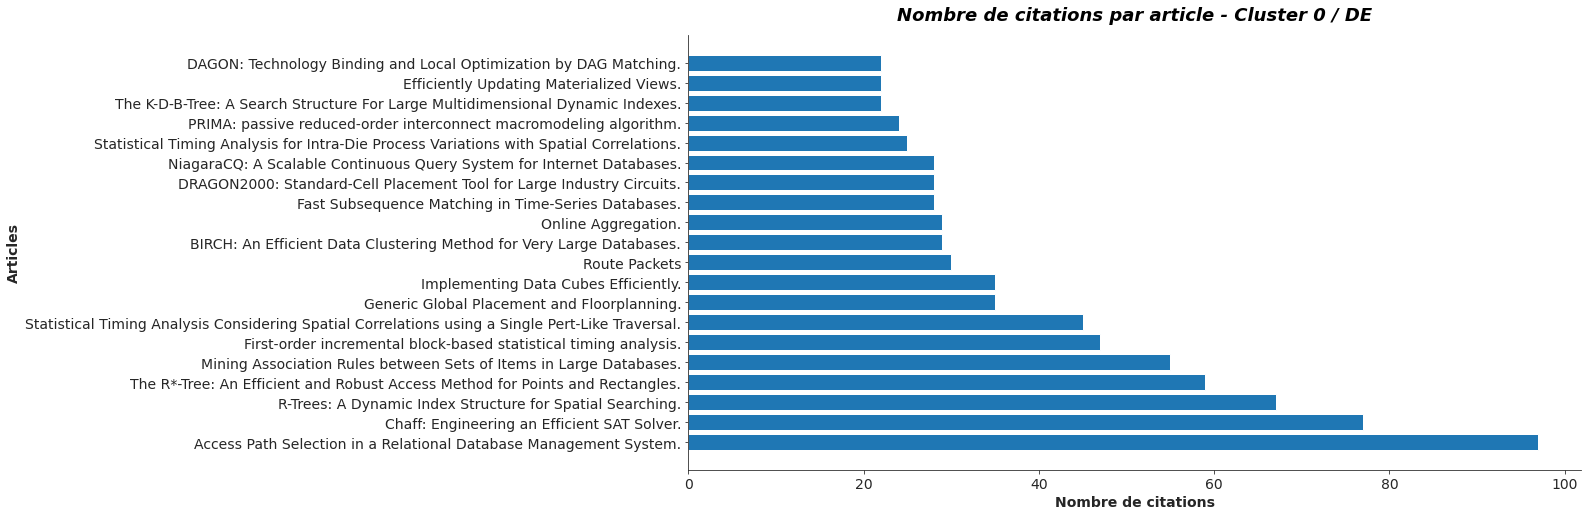

In [ ]:
ref_id = df_doc_ent_clust_0["Reference_id"]
refs=[]
for x in ref_id :
    if x:
        x[-1]+=","
        refs.append(",".join(x))
    
ref_sent = " ".join(refs)

df_ref = pd.DataFrame(word_count(ref_sent).items(), columns=['Article', 'Occurence'])
df_ref.sort_values(by=['Occurence'], ascending=False, inplace=True)
df_ref.columns = ["ref_article","Occurence"]

true_ref = list(new_frame["Index_id"])
df_ref.drop(df_ref[~df_ref["ref_article"].isin(true_ref)].index, inplace=True)

ref_list=list(df_ref["ref_article"])
title_list=[]
for x in ref_list:
    title_list.append(pd.DataFrame(new_frame['PaperTitle'])[new_frame["Index_id"]==x].iloc[0,0])
df_ref["PaperTitle"] = title_list

plt.figure(figsize=(16,8))
plt.xlabel("Nombre de citations", fontsize=14,fontweight='bold')
plt.ylabel("Articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Nombre de citations par article - Cluster 0 / DE", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ref["PaperTitle"].head(20), df_ref["Occurence"].head(20))

###### Cluster 1 / Matrice documents-entités

<BarContainer object of 20 artists>

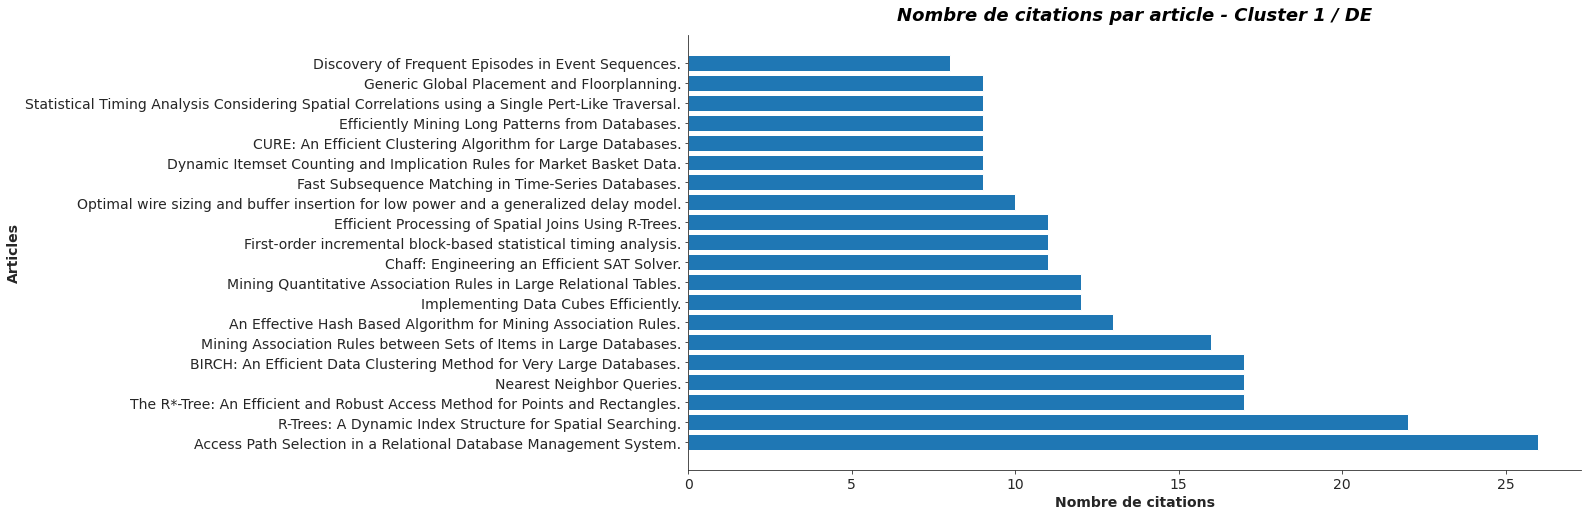

In [ ]:
ref_id = df_doc_ent_clust_1["Reference_id"]
refs=[]
for x in ref_id :
    if x:
        x[-1]+=","
        refs.append(",".join(x))
    
ref_sent = " ".join(refs)

df_ref = pd.DataFrame(word_count(ref_sent).items(), columns=['Article', 'Occurence'])
df_ref.sort_values(by=['Occurence'], ascending=False, inplace=True)
df_ref.columns = ["ref_article","Occurence"]

true_ref = list(new_frame["Index_id"])
df_ref.drop(df_ref[~df_ref["ref_article"].isin(true_ref)].index, inplace=True)

ref_list=list(df_ref["ref_article"])
title_list=[]
for x in ref_list:
    title_list.append(pd.DataFrame(new_frame['PaperTitle'])[new_frame["Index_id"]==x].iloc[0,0])
df_ref["PaperTitle"] = title_list

plt.figure(figsize=(16,8))
plt.xlabel("Nombre de citations", fontsize=14,fontweight='bold')
plt.ylabel("Articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Nombre de citations par article - Cluster 1 / DE", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ref["PaperTitle"].head(20), df_ref["Occurence"].head(20))

### Spherical K-Means

Vu que la SVD ne marche pas avec le Spherical K-Means, nous allons pensé à utiliser le paramètre **max_features** de la fonction **CountVectorizer()** pour réduire la dimensionnalité des matrices documents-termes / document-entités. Nous avons fixé le paramètre **max_features=3000** après quelques tentatives qui avaient but de trouver un compromis entre la qualité de l'information et le temps nécessaire d'exécution.

#### Application de la méthode de coude sur la matrice documents-termes

In [ ]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = coclust.clustering.SphericalKmeans(n_clusters=k, random_state = 0 , n_init=1)
    kmeanModel.fit(S_DocTerm_abstract)
    distortions.append(kmeanModel.criterion)

 == New init == 
iteration: 0
3436.067307828389
iteration: 1
 == New init == 
iteration: 0
3454.666120633721
iteration: 1
3591.890714467043
iteration: 2
3657.3391048000385
iteration: 3
3680.36473821529
iteration: 4
3694.465350466462
iteration: 5
3703.698188099412
iteration: 6
3708.9499000946917
iteration: 7
3710.384846080299
iteration: 8
3711.453878857128
iteration: 9
3713.1411316224403
iteration: 10
3715.803651520334
iteration: 11
3717.331980913701
iteration: 12
3717.9729855317087
iteration: 13
3718.22922383916
iteration: 14
3718.349586731206
iteration: 15
3718.400410299083
iteration: 16
3718.4188228250437
iteration: 17
3718.427758308124
iteration: 18
3718.4399008480996
iteration: 19
3718.449385578313
 == New init == 
iteration: 0
3466.696680807684
iteration: 1
3668.994013979943
iteration: 2
3795.97761533527
iteration: 3
3818.4758698401574
iteration: 4
3824.7726479110524
iteration: 5
3828.1486054648944
iteration: 6
3830.8650993241226
iteration: 7
3834.8947866267704
iteration: 8
3841.8

#### Plot généré par la méthode de coude pour la matrice documents-termes

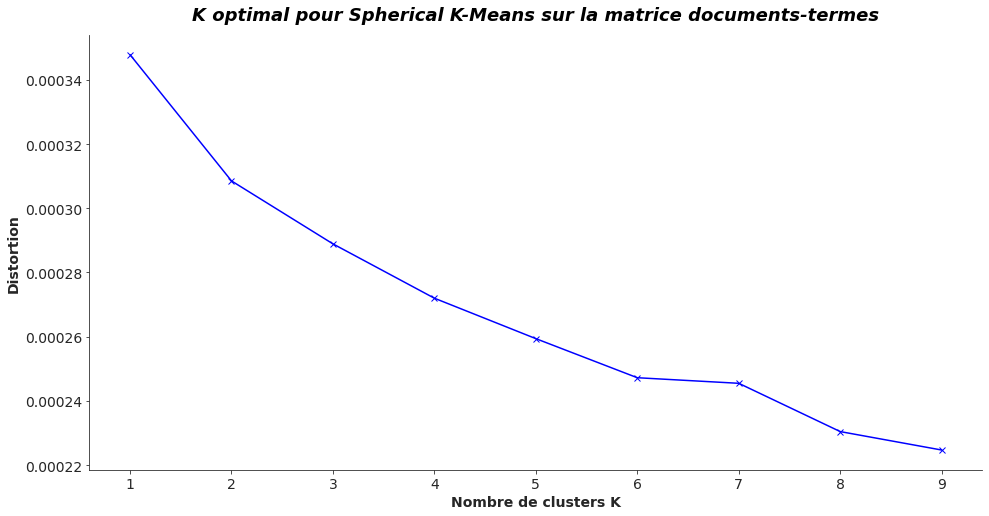

In [ ]:
plt.figure(figsize=(16,8))
plt.xlabel("Nombre de clusters K", fontsize=14,fontweight='bold')
plt.ylabel('Distortion', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('K optimal pour Spherical K-Means sur la matrice documents-termes', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.plot(K, [1/dis for dis in distortions], 'bx-')
plt.show()

Nous observons un point d'inflexion pour K=2 et donc nous allons procéder avec 2 clusters pour le Spherical K-Means sur la matrice documents-termes.

#### Application de la méthode de coude sur la matrice documents-entités

In [ ]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = coclust.clustering.SphericalKmeans(n_clusters=k, random_state = 0 , n_init=1)
    kmeanModel.fit(Xs_entity_linking)
    distortions.append(kmeanModel.criterion)

 == New init == 
iteration: 0
2874.7531246974904
iteration: 1
 == New init == 
iteration: 0
2905.203218638565
iteration: 1
3145.4421461265574
iteration: 2
3218.357702853522
iteration: 3
3230.447750584467
iteration: 4
3234.941559997137
iteration: 5
3237.9165287279384
iteration: 6
3239.8562126880724
iteration: 7
3240.647860333698
iteration: 8
3240.933946496764
iteration: 9
3241.0588589163244
iteration: 10
3241.1096790756337
iteration: 11
3241.1388458994134
iteration: 12
3241.1666531539367
iteration: 13
3241.182948714216
iteration: 14
3241.1950223982813
iteration: 15
3241.204735290871
iteration: 16
3241.2087946486704
iteration: 17
3241.2110202046497
iteration: 18
3241.212458860884
iteration: 19
3241.213109048957
 == New init == 
iteration: 0
2922.283997311585
iteration: 1
3178.6382834722144
iteration: 2
3320.0416222858425
iteration: 3
3375.904300278009
iteration: 4
3400.2377445897123
iteration: 5
3414.19648946056
iteration: 6
3422.2719011205963
iteration: 7
3428.1225080841973
iteration: 8

#### Plot généré par la méthode de coude pour la matrice documents-entités

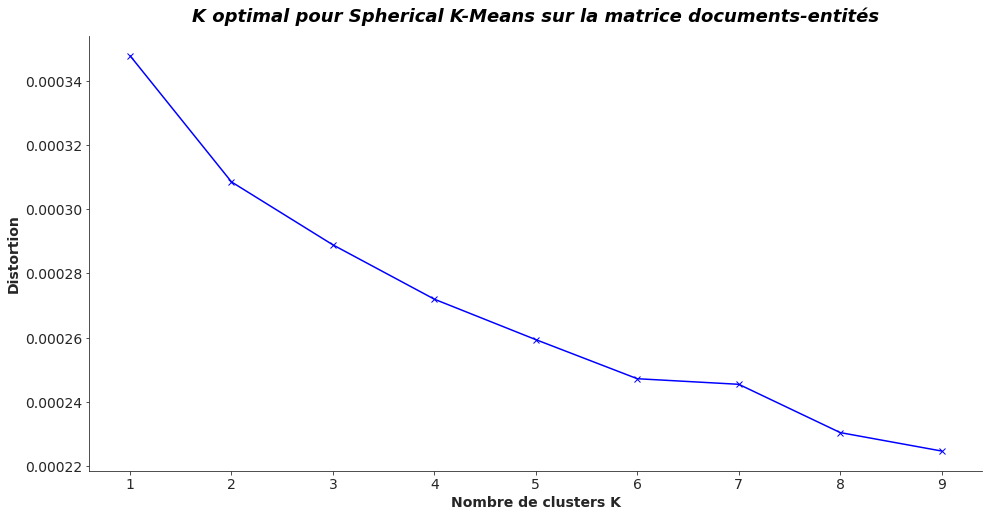

In [ ]:
plt.figure(figsize=(16,8))
plt.xlabel("Nombre de clusters K", fontsize=14,fontweight='bold')
plt.ylabel('Distortion', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('K optimal pour Spherical K-Means sur la matrice documents-entités', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.plot(K, [1/dis for dis in distortions], 'bx-')
plt.show()

Pareil à la matrice document-termes, nous remarquons un point d'inflexion pour K=2. Nous allons donc procéder avec 2 clusters pour le Spherical K-Means sur la matrice documents-entités.

#### Application du K-Means avec K=2 sur la matrice documents-termes

In [ ]:
s_kmeans_doc_term = coclust.clustering.SphericalKmeans(n_clusters=2, random_state = 0 , n_init=1)
s_kmeans_doc_term.fit(S_DocTerm_abstract)
s_labels_doc_term = s_kmeans_doc_term.labels_ # Récupérer les labels
new_frame["S_Labels_Doc_Term"] = s_labels_doc_term # Insérer une nouvelle variable contenant les labels dans la base de données

 == New init == 
iteration: 0
3454.666120633721
iteration: 1
3591.890714467043
iteration: 2
3657.3391048000385
iteration: 3
3680.36473821529
iteration: 4
3694.465350466462
iteration: 5
3703.698188099412
iteration: 6
3708.9499000946917
iteration: 7
3710.384846080299
iteration: 8
3711.453878857128
iteration: 9
3713.1411316224403
iteration: 10
3715.803651520334
iteration: 11
3717.331980913701
iteration: 12
3717.9729855317087
iteration: 13
3718.22922383916
iteration: 14
3718.349586731206
iteration: 15
3718.400410299083
iteration: 16
3718.4188228250437
iteration: 17
3718.427758308124
iteration: 18
3718.4399008480996
iteration: 19
3718.449385578313


#### Application du K-Means avec K=2 sur la matrice documents-entités

In [ ]:
s_kmeans_doc_ent = coclust.clustering.SphericalKmeans(n_clusters=2, random_state = 0 , n_init=1)
s_kmeans_doc_ent.fit(Xs_entity_linking)
s_labels_doc_ent = s_kmeans_doc_ent.labels_ # Récupérer les labels
new_frame["S_Labels_Doc_Entity"] = s_labels_doc_ent # Insérer une nouvelle variable contenant les labels dans la base de données

 == New init == 
iteration: 0
2905.203218638565
iteration: 1
3145.4421461265574
iteration: 2
3218.357702853522
iteration: 3
3230.447750584467
iteration: 4
3234.941559997137
iteration: 5
3237.9165287279384
iteration: 6
3239.8562126880724
iteration: 7
3240.647860333698
iteration: 8
3240.933946496764
iteration: 9
3241.0588589163244
iteration: 10
3241.1096790756337
iteration: 11
3241.1388458994134
iteration: 12
3241.1666531539367
iteration: 13
3241.182948714216
iteration: 14
3241.1950223982813
iteration: 15
3241.204735290871
iteration: 16
3241.2087946486704
iteration: 17
3241.2110202046497
iteration: 18
3241.212458860884
iteration: 19
3241.213109048957


#### Création des sous bases de données pour chaque cluster

In [ ]:
df_s_doc_term_clust_0 = new_frame[new_frame["S_Labels_Doc_Term"] == 0]
df_s_doc_term_clust_1 = new_frame[new_frame["S_Labels_Doc_Term"] == 1]

df_s_doc_ent_clust_0 = new_frame[new_frame["S_Labels_Doc_Entity"] == 0]
df_s_doc_ent_clust_1 = new_frame[new_frame["S_Labels_Doc_Entity"] == 1]

#### Les termes les plus fréquents

###### Cluster 0

<BarContainer object of 15 artists>

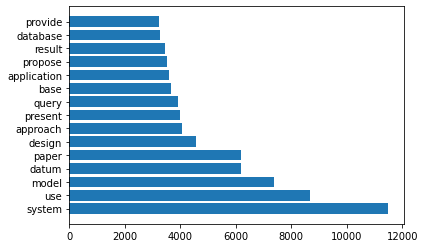

In [ ]:
abst_sent_clust0 = " ".join(list(df_s_doc_term_clust_0["Abstract"]))

def word_count_abs(str):
    counts = {}
    words = str.split(" ")

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

freq_words_clust0 = word_count_abs(abst_sent_clust0)

df_freq_words_clust0 = pd.DataFrame(freq_words_clust0.items(), columns=['Words', 'Occurence'])
df_freq_words_clust0.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Termes', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les termes les plus utilisés - Cluster 0', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh(df_freq_words_clust0["Words"].head(15), df_freq_words_clust0["Occurence"].head(15))

###### Cluster 1

<BarContainer object of 15 artists>

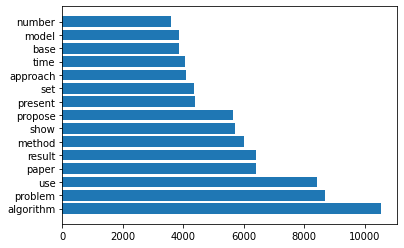

In [ ]:
abst_sent_clust1 = " ".join(list(df_s_doc_term_clust_1["Abstract"]))

def word_count_abs(str):
    counts = {}
    words = str.split(" ")

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

freq_words_clust1 = word_count_abs(abst_sent_clust1)

df_freq_words_clust1 = pd.DataFrame(freq_words_clust1.items(), columns=['Words', 'Occurence'])
df_freq_words_clust1.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Termes', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les termes les plus utilisés - Cluster 1', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh(df_freq_words_clust1["Words"].head(15), df_freq_words_clust1["Occurence"].head(15))

#### Les entités les plus fréquentes

###### Cluster 0

<BarContainer object of 15 artists>

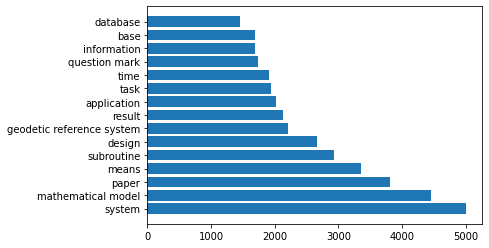

In [ ]:
ent_lab_clust0 = list(df_s_doc_ent_clust_0["Entities_labels"])
ents_clust0=[]
for x in ent_lab_clust0 :
    if x:
        x[-1]+=","
        ents_clust0.append(",".join(x))
    
ent_sent_clust0 = " ".join(ents_clust0)

freq_ent_clust0 = word_count(ent_sent_clust0)

df_ent_clust0 = pd.DataFrame(freq_ent_clust0.items(), columns=['Entities', 'Occurence'])
nan_value = float("NaN")
df_ent_clust0.replace("", nan_value, inplace=True)
df_ent_clust0.dropna(inplace=True)
df_ent_clust0.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Entités', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les entités les plus fréquentes - Cluster 0', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh(df_ent_clust0["Entities"].head(15), df_ent_clust0["Occurence"].head(15))

###### Cluster 1

<BarContainer object of 15 artists>

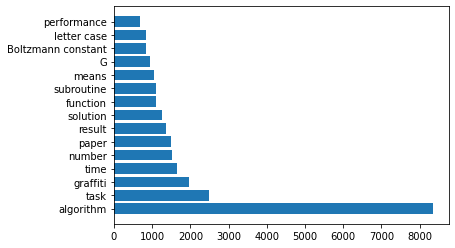

In [ ]:
ent_lab_clust0 = list(df_s_doc_ent_clust_1["Entities_labels"])
ents_clust0=[]
for x in ent_lab_clust0 :
    if x:
        x[-1]+=","
        ents_clust0.append(",".join(x))
    
ent_sent_clust0 = " ".join(ents_clust0)

freq_ent_clust0 = word_count(ent_sent_clust0)

df_ent_clust0 = pd.DataFrame(freq_ent_clust0.items(), columns=['Entities', 'Occurence'])
nan_value = float("NaN")
df_ent_clust0.replace("", nan_value, inplace=True)
df_ent_clust0.dropna(inplace=True)
df_ent_clust0.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Entités', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les entités les plus fréquentes - Cluster 1', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh(df_ent_clust0["Entities"].head(15), df_ent_clust0["Occurence"].head(15))

#### Le type de revues

###### Cluster 0 / Matrice documents-termes

<BarContainer object of 20 artists>

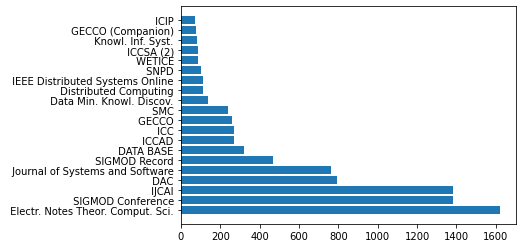

In [ ]:
pub_ven = df_s_doc_term_clust_0["Publication_venue"]
vens=[]
for x in pub_ven :
    if x:
        x+=","
        vens.append("".join(x))
    
vens_sent = " ".join(vens)

df_ven = pd.DataFrame(word_count(vens_sent).items(), columns=['Publication_venue', 'Occurence'])
df_ven.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Revues', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les types de revues - Cluster 0 / DT', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ven["Publication_venue"].head(20), df_ven["Occurence"].head(20))

###### Cluster 1 / Matrice documents-termes

<BarContainer object of 20 artists>

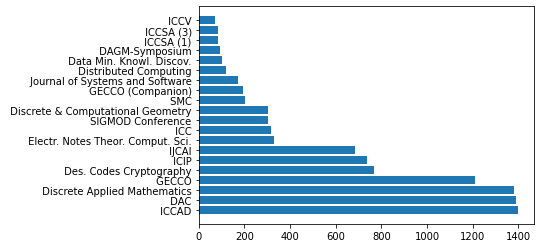

In [ ]:
pub_ven = df_s_doc_term_clust_1["Publication_venue"]
vens=[]
for x in pub_ven :
    if x:
        x+=","
        vens.append("".join(x))
    
vens_sent = " ".join(vens)

df_ven = pd.DataFrame(word_count(vens_sent).items(), columns=['Publication_venue', 'Occurence'])
df_ven.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Revues', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les types de revues - Cluster 1 / DT', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ven["Publication_venue"].head(20), df_ven["Occurence"].head(20))

###### Cluster 0 / Matrice documents-entités

<BarContainer object of 20 artists>

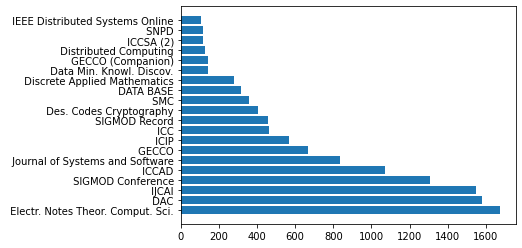

In [ ]:
pub_ven = df_s_doc_ent_clust_0["Publication_venue"]
vens=[]
for x in pub_ven :
    if x:
        x+=","
        vens.append("".join(x))
    
vens_sent = " ".join(vens)

df_ven = pd.DataFrame(word_count(vens_sent).items(), columns=['Publication_venue', 'Occurence'])
df_ven.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Revues', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les types de revues - Cluster 0 / DE', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ven["Publication_venue"].head(20), df_ven["Occurence"].head(20))

###### Cluster 1 / Matrice documents-entités

<BarContainer object of 20 artists>

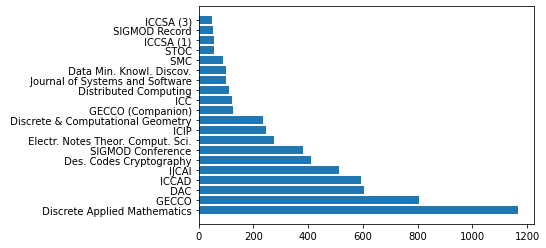

In [ ]:
pub_ven = df_s_doc_ent_clust_1["Publication_venue"]
vens=[]
for x in pub_ven :
    if x:
        x+=","
        vens.append("".join(x))
    
vens_sent = " ".join(vens)

df_ven = pd.DataFrame(word_count(vens_sent).items(), columns=['Publication_venue', 'Occurence'])
df_ven.sort_values(by=['Occurence'], ascending=False, inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Occurence", fontsize=14,fontweight='bold')
plt.ylabel('Revues', fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Les types de revues - Cluster 1 / DE', fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ven["Publication_venue"].head(20), df_ven["Occurence"].head(20))

#### Évolution des clusters selon le temps

###### Cluster 0 / Matrice documents-termes

<BarContainer object of 20 artists>

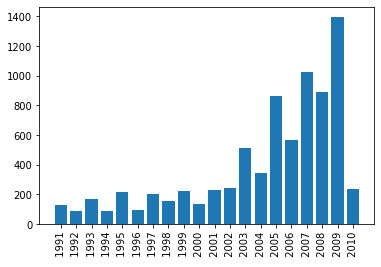

In [ ]:
year = df_s_doc_term_clust_0["Year"]
years=[]
for x in year :
    if x:
        x+=","
        years.append("".join(x))
    
year_sent = " ".join(years)

df_year = pd.DataFrame(word_count(year_sent).items(), columns=['Year', 'Occurence'])
nan_value = float("NaN")
df_year.replace("", nan_value, inplace=True)
df_year.dropna(inplace=True)
df_year.sort_values(by=['Year'], ascending=True, inplace=True)
df_year.drop(df_year.tail(1).index,inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Années", fontsize=14,fontweight='bold')
plt.ylabel("Nombre d'articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
plt.title("L'évolution selon le temps - Cluster 0 / DT", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.xticks(rotation=90)
plt.bar( df_year["Year"].tail(20), df_year["Occurence"].tail(20))

###### Cluster 1 / Matrice documents-termes

<BarContainer object of 20 artists>

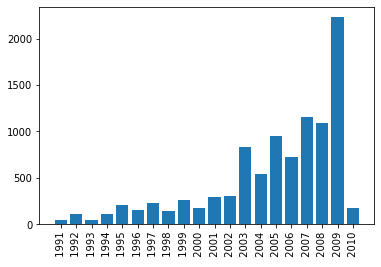

In [ ]:
year = df_s_doc_term_clust_1["Year"]
years=[]
for x in year :
    if x:
        x+=","
        years.append("".join(x))
    
year_sent = " ".join(years)

df_year = pd.DataFrame(word_count(year_sent).items(), columns=['Year', 'Occurence'])
nan_value = float("NaN")
df_year.replace("", nan_value, inplace=True)
df_year.dropna(inplace=True)
df_year.sort_values(by=['Year'], ascending=True, inplace=True)
df_year.drop(df_year.tail(1).index,inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Années", fontsize=14,fontweight='bold')
plt.ylabel("Nombre d'articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
plt.title("L'évolution selon le temps - Cluster 1 / DT", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.xticks(rotation=90)
plt.bar( df_year["Year"].tail(20), df_year["Occurence"].tail(20))

###### Cluster 0 / Matrice documents-entités

<BarContainer object of 20 artists>

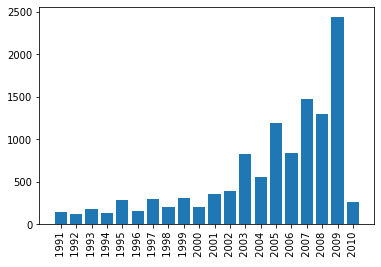

In [ ]:
year = df_s_doc_ent_clust_0["Year"]
years=[]
for x in year :
    if x:
        x+=","
        years.append("".join(x))
    
year_sent = " ".join(years)

df_year = pd.DataFrame(word_count(year_sent).items(), columns=['Year', 'Occurence'])
nan_value = float("NaN")
df_year.replace("", nan_value, inplace=True)
df_year.dropna(inplace=True)
df_year.sort_values(by=['Year'], ascending=True, inplace=True)
df_year.drop(df_year.tail(1).index,inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Années", fontsize=14,fontweight='bold')
plt.ylabel("Nombre d'articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
plt.title("L'évolution selon le temps - Cluster 0 / DE", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.xticks(rotation=90)
plt.bar( df_year["Year"].tail(20), df_year["Occurence"].tail(20))

###### Cluster 1 / Matrice documents-entités

<BarContainer object of 20 artists>

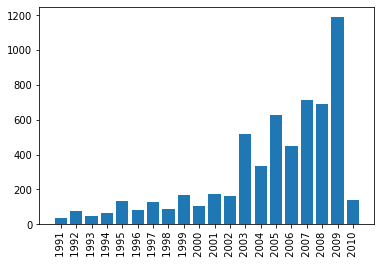

In [ ]:
year = df_s_doc_ent_clust_1["Year"]
years=[]
for x in year :
    if x:
        x+=","
        years.append("".join(x))
    
year_sent = " ".join(years)

df_year = pd.DataFrame(word_count(year_sent).items(), columns=['Year', 'Occurence'])
nan_value = float("NaN")
df_year.replace("", nan_value, inplace=True)
df_year.dropna(inplace=True)
df_year.sort_values(by=['Year'], ascending=True, inplace=True)
df_year.drop(df_year.tail(1).index,inplace=True)

plt.figure(figsize=(16,8))
plt.xlabel("Années", fontsize=14,fontweight='bold')
plt.ylabel("Nombre d'articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
plt.title("L'évolution selon le temps - Cluster 1 / DE", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.xticks(rotation=90)
plt.bar( df_year["Year"].tail(20), df_year["Occurence"].tail(20))

#### Distribution du nombre de citations des articles

###### Cluster 0 / Matrice documents-termes

<BarContainer object of 20 artists>

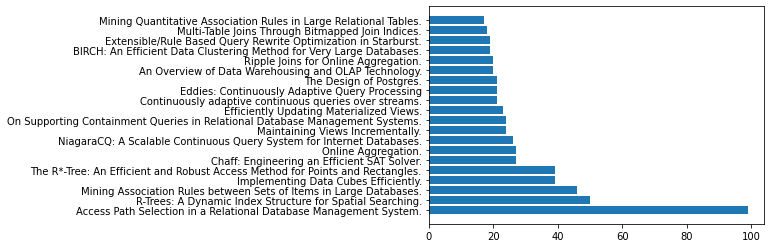

In [ ]:
ref_id = df_s_doc_term_clust_0["Reference_id"]
refs=[]
for x in ref_id :
    if x:
        x[-1]+=","
        refs.append(",".join(x))
    
ref_sent = " ".join(refs)

df_ref = pd.DataFrame(word_count(ref_sent).items(), columns=['Article', 'Occurence'])
df_ref.sort_values(by=['Occurence'], ascending=False, inplace=True)
df_ref.columns = ["ref_article","Occurence"]

true_ref = list(new_frame["Index_id"])
df_ref.drop(df_ref[~df_ref["ref_article"].isin(true_ref)].index, inplace=True)

ref_list=list(df_ref["ref_article"])
title_list=[]
for x in ref_list:
    title_list.append(pd.DataFrame(new_frame['PaperTitle'])[new_frame["Index_id"]==x].iloc[0,0])
df_ref["PaperTitle"] = title_list

plt.figure(figsize=(16,8))
plt.xlabel("Nombre de citations", fontsize=14,fontweight='bold')
plt.ylabel("Articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Nombre de citations par article - Cluster 0 / DT", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ref["PaperTitle"].head(20), df_ref["Occurence"].head(20))

###### Cluster 1 / Matrice documents-termes

<BarContainer object of 20 artists>

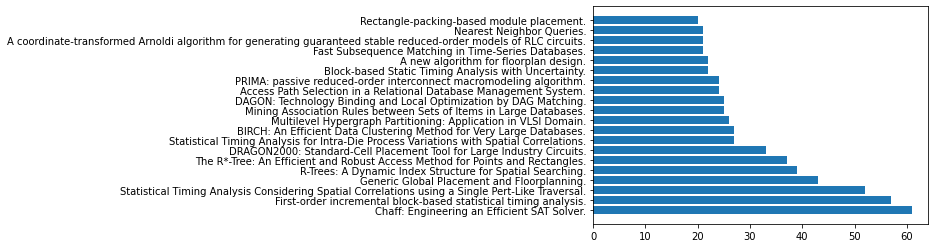

In [ ]:
ref_id = df_s_doc_term_clust_1["Reference_id"]
refs=[]
for x in ref_id :
    if x:
        x[-1]+=","
        refs.append(",".join(x))
    
ref_sent = " ".join(refs)

df_ref = pd.DataFrame(word_count(ref_sent).items(), columns=['Article', 'Occurence'])
df_ref.sort_values(by=['Occurence'], ascending=False, inplace=True)
df_ref.columns = ["ref_article","Occurence"]

true_ref = list(new_frame["Index_id"])
df_ref.drop(df_ref[~df_ref["ref_article"].isin(true_ref)].index, inplace=True)

ref_list=list(df_ref["ref_article"])
title_list=[]
for x in ref_list:
    title_list.append(pd.DataFrame(new_frame['PaperTitle'])[new_frame["Index_id"]==x].iloc[0,0])
df_ref["PaperTitle"] = title_list

plt.figure(figsize=(16,8))
plt.xlabel("Nombre de citations", fontsize=14,fontweight='bold')
plt.ylabel("Articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Nombre de citations par article - Cluster 1 / DT", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ref["PaperTitle"].head(20), df_ref["Occurence"].head(20))

###### Cluster 0 / Matrice documents-entités

<BarContainer object of 20 artists>

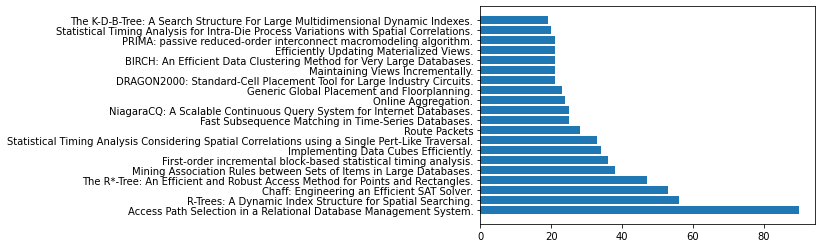

In [ ]:
ref_id = df_s_doc_ent_clust_0["Reference_id"]
refs=[]
for x in ref_id :
    if x:
        x[-1]+=","
        refs.append(",".join(x))
    
ref_sent = " ".join(refs)

df_ref = pd.DataFrame(word_count(ref_sent).items(), columns=['Article', 'Occurence'])
df_ref.sort_values(by=['Occurence'], ascending=False, inplace=True)
df_ref.columns = ["ref_article","Occurence"]

true_ref = list(new_frame["Index_id"])
df_ref.drop(df_ref[~df_ref["ref_article"].isin(true_ref)].index, inplace=True)

ref_list=list(df_ref["ref_article"])
title_list=[]
for x in ref_list:
    title_list.append(pd.DataFrame(new_frame['PaperTitle'])[new_frame["Index_id"]==x].iloc[0,0])
df_ref["PaperTitle"] = title_list

plt.figure(figsize=(16,8))
plt.xlabel("Nombre de citations", fontsize=14,fontweight='bold')
plt.ylabel("Articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Nombre de citations par article - Cluster 0 / DE", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ref["PaperTitle"].head(20), df_ref["Occurence"].head(20))

###### Cluster 1 / Matrice documents-entités

<BarContainer object of 20 artists>

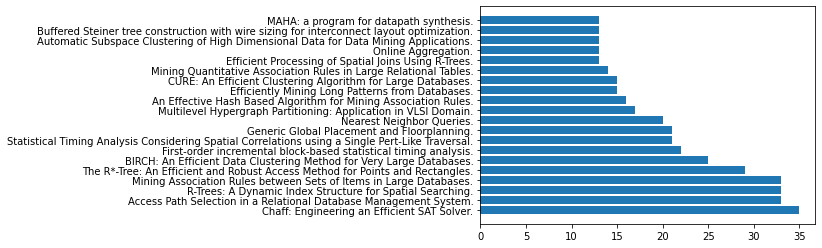

In [ ]:
ref_id = df_s_doc_ent_clust_1["Reference_id"]
refs=[]
for x in ref_id :
    if x:
        x[-1]+=","
        refs.append(",".join(x))
    
ref_sent = " ".join(refs)

df_ref = pd.DataFrame(word_count(ref_sent).items(), columns=['Article', 'Occurence'])
df_ref.sort_values(by=['Occurence'], ascending=False, inplace=True)
df_ref.columns = ["ref_article","Occurence"]

true_ref = list(new_frame["Index_id"])
df_ref.drop(df_ref[~df_ref["ref_article"].isin(true_ref)].index, inplace=True)

ref_list=list(df_ref["ref_article"])
title_list=[]
for x in ref_list:
    title_list.append(pd.DataFrame(new_frame['PaperTitle'])[new_frame["Index_id"]==x].iloc[0,0])
df_ref["PaperTitle"] = title_list

plt.figure(figsize=(16,8))
plt.xlabel("Nombre de citations", fontsize=14,fontweight='bold')
plt.ylabel("Articles", fontsize=14,fontweight='bold')
sns.set_style('ticks') # Arrière plan blanc
sns.despine() # Eliminer les bordures à droite et en haut
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Nombre de citations par article - Cluster 1 / DE", fontsize=18,fontweight='bold',color='black',fontstyle='italic',y=1.02)
plt.barh( df_ref["PaperTitle"].head(20), df_ref["Occurence"].head(20))